In [ ]:
!pip install kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 5.1 MB/s eta 0:00:00


In [ ]:
!pip install tomli

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 16.4 MB/s eta 0:00:00


In [ ]:
!pip install synthcity

In [ ]:
!pip install sdmetrics

In [1]:
import os
from urllib import request
import numpy as np
import pandas as pd
import zipfile
import json
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import time
import numpy as np
from dataclasses import astuple, dataclass, replace
from typing import Any, Literal, Optional, Union, cast, Tuple, Dict, List
import torch
from pathlib import Path
import enum
from torch import nn
import sklearn
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
import torch
import torch.nn.init as nn_init
import torch.nn.functional as F
from torch import Tensor
import math
import kaleido
import plotly
import tomli

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
if torch.cuda.is_available():
    my_device = torch.device('cuda')
else:
    my_device = torch.device('cpu')
print('Device: {}'.format(my_device))

Device: cuda


### Load Adult

In [4]:
class Adult_Dataset():

    def __init__(self, name):
        super(Adult_Dataset, self).__init__()
        self.name = name

    def download_from_uci(self):

        print(f'Start processing dataset {self.name} from UCI.')
        save_dir = f'data/{self.name}'
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

            url = 'https://archive.ics.uci.edu/static/public/2/adult.zip'
            request.urlretrieve(url, f'{save_dir}/{self.name}.zip')
            print(
                f'Finish downloading dataset from {url}, data has been saved to {save_dir}.')

            with zipfile.ZipFile(f'{save_dir}/{self.name}.zip', 'r') as zip_ref:
                zip_ref.extractall(save_dir)

            print(f'Finish unzipping {self.name}.')

        else:
            print('Aready downloaded.')

    def get_column_name_mapping(self, data_df, num_col_idx, cat_col_idx, target_col_idx, column_names=None):

        idx_mapping = {}

        curr_num_idx = 0
        curr_cat_idx = len(num_col_idx)
        curr_target_idx = curr_cat_idx + len(cat_col_idx)

        for idx in range(len(column_names)):

            if idx in num_col_idx:
                idx_mapping[int(idx)] = curr_num_idx
                curr_num_idx += 1
            elif idx in cat_col_idx:
                idx_mapping[int(idx)] = curr_cat_idx
                curr_cat_idx += 1
            else:
                idx_mapping[int(idx)] = curr_target_idx
                curr_target_idx += 1

        inverse_idx_mapping = {}
        for k, v in idx_mapping.items():
            inverse_idx_mapping[int(v)] = k

        idx_name_mapping = {}

        for i in range(len(column_names)):
            idx_name_mapping[int(i)] = column_names[i]

        return idx_mapping, inverse_idx_mapping, idx_name_mapping

    def process_data(self):
        with open(f'data/Info/{self.name}.json', 'r') as f:
            info = json.load(f)
        data_path = info['data_path']
        data_df = pd.read_csv(data_path, header=None)

        num_data = data_df.shape[0]

        column_names = [
            "age",
            "workclass",
            "fnlwgt",
            "education",
            "education.num",
            "marital.status",
            "occupation",
            "relationship",
            "race",
            "sex",
            "capital.gain",
            "capital.loss",
            "hours.per.week",
            "native.country",
            "income"
        ]

        num_col_idx = info['num_col_idx']
        cat_col_idx = info['cat_col_idx']
        target_col_idx = info['target_col_idx']

        idx_mapping, inverse_idx_mapping, idx_name_mapping = self.get_column_name_mapping(
            data_df, num_col_idx, cat_col_idx, target_col_idx, column_names)

        num_columns = [column_names[i] for i in num_col_idx]
        cat_columns = [column_names[i] for i in cat_col_idx]
        target_columns = [column_names[i] for i in target_col_idx]

        # if testing data is given
        test_path = info['test_path']

        with open(test_path, 'r') as f:
            lines = f.readlines()[1:]
            test_save_path = f'data/{self.name}/test.data'
            if not os.path.exists(test_save_path):
                with open(test_save_path, 'a') as f1:
                    for line in lines:
                        save_line = line.strip('\n').strip('.')
                        f1.write(f'{save_line}\n')

        test_df = pd.read_csv(test_save_path, header=None)
        train_df = data_df

        train_df.columns = range(len(train_df.columns))
        test_df.columns = range(len(test_df.columns))

        print(self.name, train_df.shape, test_df.shape, data_df.shape)

        col_info = {}

        for col_idx in num_col_idx:
            col_info[col_idx] = {}
            col_info['type'] = 'numerical'
            col_info['max'] = float(train_df[col_idx].max())
            col_info['min'] = float(train_df[col_idx].min())

        for col_idx in cat_col_idx:
            col_info[col_idx] = {}
            col_info['type'] = 'categorical'
            col_info['categorizes'] = list(set(train_df[col_idx]))

        for col_idx in target_col_idx:
            col_info[col_idx] = {}
            col_info['type'] = 'categorical'
            col_info['categorizes'] = list(set(train_df[col_idx]))

        info['column_info'] = col_info

        train_df.rename(columns=idx_name_mapping, inplace=True)
        test_df.rename(columns=idx_name_mapping, inplace=True)

        for col in num_columns:
            train_df.loc[train_df[col] == '?', col] = np.nan
        for col in cat_columns:
            train_df.loc[train_df[col] == '?', col] = 'nan'
        for col in num_columns:
            test_df.loc[test_df[col] == '?', col] = np.nan
        for col in cat_columns:
            test_df.loc[test_df[col] == '?', col] = 'nan'

        X_num_train = train_df[num_columns].to_numpy().astype(np.float32)
        X_cat_train = train_df[cat_columns].to_numpy()
        y_train = train_df[target_columns].to_numpy()

        X_num_test = test_df[num_columns].to_numpy().astype(np.float32)
        X_cat_test = test_df[cat_columns].to_numpy()
        y_test = test_df[target_columns].to_numpy()

        save_dir = f'data/{self.name}'
        np.save(f'{save_dir}/X_num_train.npy', X_num_train)
        np.save(f'{save_dir}/X_cat_train.npy', X_cat_train)
        np.save(f'{save_dir}/y_train.npy', y_train)

        np.save(f'{save_dir}/X_num_test.npy', X_num_test)
        np.save(f'{save_dir}/X_cat_test.npy', X_cat_test)
        np.save(f'{save_dir}/y_test.npy', y_test)

        train_df[num_columns] = train_df[num_columns].astype(np.float32)
        test_df[num_columns] = test_df[num_columns].astype(np.float32)

        train_df.to_csv(f'{save_dir}/train.csv', index=False)
        test_df.to_csv(f'{save_dir}/test.csv', index=False)

        if not os.path.exists(f'synthetic/{self.name}'):
            os.makedirs(f'synthetic/{self.name}')

        train_df.to_csv(f'synthetic/{self.name}/real.csv', index=False)
        test_df.to_csv(f'synthetic/{self.name}/test.csv', index=False)

        print('Numerical', X_num_train.shape)
        print('Categorical', X_cat_train.shape)

        info['column_names'] = column_names
        info['train_num'] = train_df.shape[0]
        info['test_num'] = test_df.shape[0]

        info['idx_mapping'] = idx_mapping
        info['inverse_idx_mapping'] = inverse_idx_mapping
        info['idx_name_mapping'] = idx_name_mapping

        metadata = {'columns': {}}
        num_col_idx = info['num_col_idx']
        cat_col_idx = info['cat_col_idx']
        target_col_idx = info['target_col_idx']

        for i in num_col_idx:
            metadata['columns'][i] = {}
            metadata['columns'][i]['sdtype'] = 'numerical'
            metadata['columns'][i]['computer_representation'] = 'Float'

        for i in cat_col_idx:
            metadata['columns'][i] = {}
            metadata['columns'][i]['sdtype'] = 'categorical'

        for i in target_col_idx:
            metadata['columns'][i] = {}
            metadata['columns'][i]['sdtype'] = 'categorical'

        info['metadata'] = metadata

        with open(f'{save_dir}/info.json', 'w') as file:
            json.dump(info, file, indent=4)

        print(f'Processing and Saving {self.name} Successfully!')

        print(self.name)
        print('Total', info['train_num'] + info['test_num'])
        print('Train', info['train_num'])
        print('Test', info['test_num'])
        cat = len(info['cat_col_idx'] + info['target_col_idx'])
        num = len(info['num_col_idx'])
        print('Num', num)
        print('Cat', cat)

    def start_load(self):
        self.download_from_uci()
        self.process_data()

In [ ]:
data_load = Adult_Dataset('adult')
data_load.download_from_uci()
data_load.process_data()

Start processing dataset adult from UCI.


HTTPError: HTTP Error 502: Bad Gateway

## TabDDPM

In [5]:

ArrayDict = Dict[str, np.ndarray]
TensorDict = Dict[str, torch.Tensor]


CAT_MISSING_VALUE = 'nan'
CAT_RARE_VALUE = '__rare__'
Normalization = Literal['standard', 'quantile', 'minmax']
NumNanPolicy = Literal['drop-rows', 'mean']
CatNanPolicy = Literal['most_frequent']
CatEncoding = Literal['one-hot', 'counter']
YPolicy = Literal['default']

Normalization = Literal['standard', 'quantile', 'minmax']
NumNanPolicy = Literal['drop-rows', 'mean']
CatNanPolicy = Literal['most_frequent']
CatEncoding = Literal['one-hot', 'counter']
YPolicy = Literal['default']
ArrayDict = Dict[str, np.ndarray]
TensorDict = Dict[str, torch.Tensor]


class TaskType(enum.Enum):
    BINCLASS = 'binclass'
    MULTICLASS = 'multiclass'
    REGRESSION = 'regression'

    def __str__(self) -> str:
        return self.value


@dataclass(frozen=True)
class Transformations:
    seed: int = 0
    normalization: Optional[Normalization] = None
    num_nan_policy: Optional[NumNanPolicy] = None
    cat_nan_policy: Optional[CatNanPolicy] = None
    cat_min_frequency: Optional[float] = None
    cat_encoding: Optional[CatEncoding] = None
    y_policy: Optional[YPolicy] = 'default'


@dataclass(frozen=False)
class Dataset:
    X_num: Optional[ArrayDict]
    X_cat: Optional[ArrayDict]
    y: ArrayDict
    y_info: Dict[str, Any]
    task_type: TaskType
    n_classes: Optional[int]

    @classmethod
    def from_dir(cls, dir_: Union[Path, str]) -> 'Dataset':
        dir_ = Path(dir_)
        splits = [k for k in ['train', 'test']
                  if dir_.joinpath(f'y_{k}.npy').exists()]

        def load(item) -> ArrayDict:
            return {
                # type: ignore[code]
                x: cast(np.ndarray, np.load(
                    dir_ / f'{item}_{x}.npy', allow_pickle=True))
                for x in splits
            }

        if Path(dir_ / 'info.json').exists():
            info = load_json(dir_ / 'info.json')
        else:
            info = None
        return Dataset(
            load('X_num') if dir_.joinpath(
                'X_num_train.npy').exists() else None,
            load('X_cat') if dir_.joinpath(
                'X_cat_train.npy').exists() else None,
            load('y'),
            {},
            TaskType(info['task_type']),
            info.get('n_classes'),
        )

    @property
    def is_binclass(self) -> bool:
        return self.task_type == TaskType.BINCLASS

    @property
    def is_multiclass(self) -> bool:
        return self.task_type == TaskType.MULTICLASS

    @property
    def is_regression(self) -> bool:
        return self.task_type == TaskType.REGRESSION

    @property
    def n_num_features(self) -> int:
        return 0 if self.X_num is None else self.X_num['train'].shape[1]

    @property
    def n_cat_features(self) -> int:
        return 0 if self.X_cat is None else self.X_cat['train'].shape[1]

    @property
    def n_features(self) -> int:
        return self.n_num_features + self.n_cat_features

    def size(self, part: Optional[str]) -> int:
        return sum(map(len, self.y.values())) if part is None else len(self.y[part])

    @property
    def nn_output_dim(self) -> int:
        if self.is_multiclass:
            assert self.n_classes is not None
            return self.n_classes
        else:
            return 1

    def get_category_sizes(self, part: str) -> List[int]:
        return [] if self.X_cat is None else get_category_sizes(self.X_cat[part])

    def calculate_metrics(
        self,
        predictions: Dict[str, np.ndarray],
        prediction_type: Optional[str],
    ) -> Dict[str, Any]:
        metrics = {
            x: calculate_metrics(
                self.y[x], predictions[x], self.task_type, prediction_type, self.y_info
            )
            for x in predictions
        }
        if self.task_type == TaskType.REGRESSION:
            score_key = 'rmse'
            score_sign = -1
        else:
            score_key = 'accuracy'
            score_sign = 1
        for part_metrics in metrics.values():
            part_metrics['score'] = score_sign * part_metrics[score_key]
        return metrics


class TabularDataset(Dataset):
    def __init__(self, X_num, X_cat):
        self.X_num = X_num
        self.X_cat = X_cat

    def __getitem__(self, index):
        this_num = self.X_num[index]
        this_cat = self.X_cat[index]

        sample = (this_num, this_cat)

        return sample

    def __len__(self):
        return self.X_num.shape[0]


def num_process_nans(dataset: Dataset, policy: Optional[NumNanPolicy]) -> Dataset:

    assert dataset.X_num is not None
    nan_masks = {k: np.isnan(v) for k, v in dataset.X_num.items()}
    if not any(x.any() for x in nan_masks.values()):  # type: ignore[code]
        # assert policy is None
        print('No NaNs in numerical features, skipping')
        return dataset

    assert policy is not None
    if policy == 'drop-rows':
        valid_masks = {k: ~v.any(1) for k, v in nan_masks.items()}
        assert valid_masks[
            'test'
        ].all(), 'Cannot drop test rows, since this will affect the final metrics.'
        new_data = {}
        for data_name in ['X_num', 'X_cat', 'y']:
            data_dict = getattr(dataset, data_name)
            if data_dict is not None:
                new_data[data_name] = {
                    k: v[valid_masks[k]] for k, v in data_dict.items()
                }
        dataset = replace(dataset, **new_data)
    elif policy == 'mean':
        new_values = np.nanmean(dataset.X_num['train'], axis=0)
        X_num = deepcopy(dataset.X_num)
        for k, v in X_num.items():
            num_nan_indices = np.where(nan_masks[k])
            v[num_nan_indices] = np.take(new_values, num_nan_indices[1])
        dataset = replace(dataset, X_num=X_num)
    # else:
    #     assert raise_unknown('policy', policy)
    return dataset


def normalize(
    X: ArrayDict, normalization: Normalization, seed: Optional[int], return_normalizer: bool = False
) -> ArrayDict:
    X_train = X['train']
    if normalization == 'standard':
        normalizer = preprocessing.StandardScaler()
    elif normalization == 'minmax':
        normalizer = preprocessing.MinMaxScaler()
    elif normalization == 'quantile':
        normalizer = preprocessing.QuantileTransformer(
            output_distribution='normal',
            n_quantiles=max(min(X['train'].shape[0] // 30, 1000), 10),
            subsample=int(1e9),
            random_state=seed,
        )
    # else:
    #     raise_unknown('normalization', normalization)

    normalizer.fit(X_train)
    if return_normalizer:
        return {k: normalizer.transform(v) for k, v in X.items()}, normalizer
    return {k: normalizer.transform(v) for k, v in X.items()}


def cat_process_nans(X: ArrayDict, policy: Optional[CatNanPolicy]) -> ArrayDict:
    assert X is not None
    nan_masks = {k: v == CAT_MISSING_VALUE for k, v in X.items()}
    if any(x.any() for x in nan_masks.values()):  # type: ignore[code]
        if policy is None:
            X_new = X
        elif policy == 'most_frequent':
            imputer = SimpleImputer(
                missing_values=CAT_MISSING_VALUE, strategy=policy)  # type: ignore[code]
            imputer.fit(X['train'])
            X_new = {k: cast(np.ndarray, imputer.transform(v))
                     for k, v in X.items()}
        # else:
        #     util.raise_unknown('categorical NaN policy', policy)
    else:
        assert policy is None
        X_new = X
    return X_new


def cat_encode(
    X: ArrayDict,
    encoding: Optional[CatEncoding],
    y_train: Optional[np.ndarray],
    seed: Optional[int],
    return_encoder: bool = False
) -> Tuple[ArrayDict, bool, Optional[Any]]:  # (X, is_converted_to_numerical)
    if encoding != 'counter':
        y_train = None

    # Step 1. Map strings to 0-based ranges

    if encoding is None:
        unknown_value = np.iinfo('int64').max - 3
        oe = preprocessing.OrdinalEncoder(
            handle_unknown='use_encoded_value',  # type: ignore[code]
            unknown_value=unknown_value,  # type: ignore[code]
            dtype='int64',  # type: ignore[code]
        ).fit(X['train'])
        encoder = make_pipeline(oe)
        encoder.fit(X['train'])
        X = {k: encoder.transform(v) for k, v in X.items()}
        max_values = X['train'].max(axis=0)
        for part in X.keys():
            if part == 'train':
                continue
            for column_idx in range(X[part].shape[1]):
                X[part][X[part][:, column_idx] == unknown_value, column_idx] = (
                    max_values[column_idx] + 1
                )
        if return_encoder:
            return (X, False, encoder)
        return (X, False)


def build_target(
    y: ArrayDict, policy: Optional[YPolicy], task_type: TaskType
) -> Tuple[ArrayDict, Dict[str, Any]]:
    info: Dict[str, Any] = {'policy': policy}
    if policy is None:
        pass
    elif policy == 'default':
        if task_type == TaskType.REGRESSION:
            mean, std = float(y['train'].mean()), float(y['train'].std())
            y = {k: (v - mean) / std for k, v in y.items()}
            info['mean'] = mean
            info['std'] = std
    # else:
    #     raise_unknown('policy', policy)
    return y, info


def transform_dataset(
    dataset: Dataset,
    transformations: Transformations,
    cache_dir: Optional[Path],
    return_transforms: bool = False
) -> Dataset:
    # WARNING: the order of transformations matters. Moreover, the current
    # implementation is not ideal in that sense.
    if cache_dir is not None:
        transformations_md5 = hashlib.md5(
            str(transformations).encode('utf-8')
        ).hexdigest()
        transformations_str = '__'.join(map(str, astuple(transformations)))
        cache_path = (
            cache_dir /
            f'cache__{transformations_str}__{transformations_md5}.pickle'
        )
        if cache_path.exists():
            cache_transformations, value = load_pickle(cache_path)
            if transformations == cache_transformations:
                print(
                    f"Using cached features: {cache_dir.name + '/' + cache_path.name}"
                )
                return value
            else:
                raise RuntimeError(f'Hash collision for {cache_path}')
    else:
        cache_path = None

    if dataset.X_num is not None:
        dataset = num_process_nans(dataset, transformations.num_nan_policy)

    num_transform = None
    cat_transform = None
    X_num = dataset.X_num

    if X_num is not None and transformations.normalization is not None:
        X_num, num_transform = normalize(
            X_num,
            transformations.normalization,
            transformations.seed,
            return_normalizer=True
        )
        num_transform = num_transform

    if dataset.X_cat is None:
        assert transformations.cat_nan_policy is None
        assert transformations.cat_min_frequency is None
        # assert transformations.cat_encoding is None
        X_cat = None
    else:
        X_cat = cat_process_nans(dataset.X_cat, transformations.cat_nan_policy)

        if transformations.cat_min_frequency is not None:
            X_cat = cat_drop_rare(X_cat, transformations.cat_min_frequency)
        X_cat, is_num, cat_transform = cat_encode(
            X_cat,
            transformations.cat_encoding,
            dataset.y['train'],
            transformations.seed,
            return_encoder=True
        )

        if is_num:
            X_num = (
                X_cat
                if X_num is None
                else {x: np.hstack([X_num[x], X_cat[x]]) for x in X_num}
            )
            X_cat = None

    y, y_info = build_target(
        dataset.y, transformations.y_policy, dataset.task_type)

    dataset = replace(dataset, X_num=X_num, X_cat=X_cat, y=y, y_info=y_info)
    dataset.num_transform = num_transform
    dataset.cat_transform = cat_transform

    # if cache_path is not None:
    #     util.dump_pickle((transformations, dataset), cache_path)
    # if return_transforms:
    # return dataset, num_transform, cat_transform
    return dataset


def get_categories(X_train_cat):
    return (
        None
        if X_train_cat is None
        else [
            len(set(X_train_cat[:, i]))
            for i in range(X_train_cat.shape[1])
        ]
    )


def read_pure_data(path, split='train'):
    y = np.load(os.path.join(path, f'y_{split}.npy'), allow_pickle=True)
    X_num = None
    X_cat = None
    if os.path.exists(os.path.join(path, f'X_num_{split}.npy')):
        X_num = np.load(os.path.join(
            path, f'X_num_{split}.npy'), allow_pickle=True)
    if os.path.exists(os.path.join(path, f'X_cat_{split}.npy')):
        X_cat = np.load(os.path.join(
            path, f'X_cat_{split}.npy'), allow_pickle=True)

    return X_num, X_cat, y


def concat_y_to_X(X, y):
    if X is None:
        return y.reshape(-1, 1)
    return np.concatenate([y.reshape(-1, 1), X], axis=1)


def load_json(path: Union[Path, str], **kwargs) -> Any:
    return json.loads(Path(path).read_text(), **kwargs)


def make_dataset(
    data_path: str,
    T: Transformations,
    task_type,
    change_val: bool,
    concat=True,
):

    X_cat = {} if os.path.exists(os.path.join(
        data_path, 'X_cat_train.npy')) else None
    X_num = {} if os.path.exists(os.path.join(
        data_path, 'X_num_train.npy')) else None
    y = {} if os.path.exists(os.path.join(data_path, 'y_train.npy')) else None

    for split in ['train', 'test']:
        X_num_t, X_cat_t, y_t = read_pure_data(data_path, split)
        if X_num is not None:
            X_num[split] = X_num_t
        if X_cat is not None:
            if concat:
                X_cat_t = concat_y_to_X(X_cat_t, y_t)
            X_cat[split] = X_cat_t
        if y is not None:
            y[split] = y_t

    # with open(f'data/Info/{self.name}.json', 'r') as f:
    #     info = json.load(f)
    info = load_json(os.path.join(data_path, 'info.json'))
    D = Dataset(
        X_num,
        X_cat,
        y,
        y_info={},
        task_type=TaskType(info['task_type']),
        n_classes=info.get('n_classes')
    )

    return transform_dataset(D, T, None)


def preprocess(dataset_path, task_type='binclass', inverse=False, cat_encoding=None, concat=True):
    T_dict = {}

    T_dict['normalization'] = "quantile"
    T_dict['num_nan_policy'] = 'mean'
    T_dict['cat_nan_policy'] = None
    T_dict['cat_min_frequency'] = None
    T_dict['cat_encoding'] = cat_encoding
    T_dict['y_policy'] = "default"

    T = Transformations(**T_dict)

    dataset = make_dataset(
        data_path=dataset_path,
        T=T,
        task_type=task_type,
        change_val=False,
        concat=concat
    )

    if cat_encoding is None:
        X_num = dataset.X_num
        X_cat = dataset.X_cat

        X_train_num, X_test_num = X_num['train'], X_num['test']
        X_train_cat, X_test_cat = X_cat['train'], X_cat['test']

        categories = get_categories(X_train_cat)
        d_numerical = X_train_num.shape[1]

        X_num = (X_train_num, X_test_num)
        X_cat = (X_train_cat, X_test_cat)

        if inverse:
            num_inverse = dataset.num_transform.inverse_transform
            cat_inverse = dataset.cat_transform.inverse_transform

            return X_num, X_cat, categories, d_numerical, num_inverse, cat_inverse
        else:
            return X_num, X_cat, categories, d_numerical
    else:
        return dataset

In [6]:
@dataclass(frozen=True)
class Transformations:
    seed: int = 0
    normalization: Optional[Normalization] = None
    num_nan_policy: Optional[NumNanPolicy] = None
    cat_nan_policy: Optional[CatNanPolicy] = None
    cat_min_frequency: Optional[float] = None
    cat_encoding: Optional[CatEncoding] = None
    y_policy: Optional[YPolicy] = 'default'
class Dataset:
    X_num: Optional[ArrayDict]
    X_cat: Optional[ArrayDict]
    y: ArrayDict
    y_info: Dict[str, Any]
    task_type: TaskType
    n_classes: Optional[int]

    @classmethod
    def from_dir(cls, dir_: Union[Path, str]) -> 'Dataset':
        dir_ = Path(dir_)
        splits = [k for k in ['train', 'test'] if dir_.joinpath(f'y_{k}.npy').exists()]

        def load(item) -> ArrayDict:
            return {
                x: cast(np.ndarray, np.load(dir_ / f'{item}_{x}.npy', allow_pickle=True))  # type: ignore[code]
                for x in splits
            }

        if Path(dir_ / 'info.json').exists():
            info = util.load_json(dir_ / 'info.json')
        else:
            info = None
        return Dataset(
            load('X_num') if dir_.joinpath('X_num_train.npy').exists() else None,
            load('X_cat') if dir_.joinpath('X_cat_train.npy').exists() else None,
            load('y'),
            {},
            TaskType(info['task_type']),
            info.get('n_classes'),
        )

    @property
    def is_binclass(self) -> bool:
        return self.task_type == TaskType.BINCLASS

    @property
    def is_multiclass(self) -> bool:
        return self.task_type == TaskType.MULTICLASS

    @property
    def is_regression(self) -> bool:
        return self.task_type == TaskType.REGRESSION

    @property
    def n_num_features(self) -> int:
        return 0 if self.X_num is None else self.X_num['train'].shape[1]

    @property
    def n_cat_features(self) -> int:
        return 0 if self.X_cat is None else self.X_cat['train'].shape[1]

    @property
    def n_features(self) -> int:
        return self.n_num_features + self.n_cat_features

    def size(self, part: Optional[str]) -> int:
        return sum(map(len, self.y.values())) if part is None else len(self.y[part])

    @property
    def nn_output_dim(self) -> int:
        if self.is_multiclass:
            assert self.n_classes is not None
            return self.n_classes
        else:
            return 1

    def get_category_sizes(self, part: str) -> List[int]:
        return [] if self.X_cat is None else get_category_sizes(self.X_cat[part])

    def calculate_metrics(
        self,
        predictions: Dict[str, np.ndarray],
        prediction_type: Optional[str],
    ) -> Dict[str, Any]:
        metrics = {
            x: calculate_metrics_(
                self.y[x], predictions[x], self.task_type, prediction_type, self.y_info
            )
            for x in predictions
        }
        if self.task_type == TaskType.REGRESSION:
            score_key = 'rmse'
            score_sign = -1
        else:
            score_key = 'accuracy'
            score_sign = 1
        for part_metrics in metrics.values():
            part_metrics['score'] = score_sign * part_metrics[score_key]
        return metrics


In [7]:
def get_category_sizes(X: Union[torch.Tensor, np.ndarray]) -> List[int]:
    XT = X.T.cpu().tolist() if isinstance(X, torch.Tensor) else X.T.tolist()
    return [len(set(x)) for x in XT]

def num_process_nans(dataset: Dataset, policy: Optional[NumNanPolicy]) -> Dataset:

    assert dataset.X_num is not None
    nan_masks = {k: np.isnan(v) for k, v in dataset.X_num.items()}
    if not any(x.any() for x in nan_masks.values()):  # type: ignore[code]
        # assert policy is None
        print('No NaNs in numerical features, skipping')
        return dataset

    assert policy is not None
    if policy == 'drop-rows':
        valid_masks = {k: ~v.any(1) for k, v in nan_masks.items()}
        assert valid_masks[
            'test'
        ].all(), 'Cannot drop test rows, since this will affect the final metrics.'
        new_data = {}
        for data_name in ['X_num', 'X_cat', 'y']:
            data_dict = getattr(dataset, data_name)
            if data_dict is not None:
                new_data[data_name] = {
                    k: v[valid_masks[k]] for k, v in data_dict.items()
                }
        dataset = replace(dataset, **new_data)
    elif policy == 'mean':
        new_values = np.nanmean(dataset.X_num['train'], axis=0)
        X_num = deepcopy(dataset.X_num)
        for k, v in X_num.items():
            num_nan_indices = np.where(nan_masks[k])
            v[num_nan_indices] = np.take(new_values, num_nan_indices[1])
        dataset = replace(dataset, X_num=X_num)
    # else:
    #     assert raise_unknown('policy', policy)
    return dataset


def normalize(
    X: ArrayDict, normalization: Normalization, seed: Optional[int], return_normalizer: bool = False
) -> ArrayDict:
    X_train = X['train']
    if normalization == 'standard':
        normalizer = preprocessing.StandardScaler()
    elif normalization == 'minmax':
        normalizer = preprocessing.MinMaxScaler()
    elif normalization == 'quantile':
        normalizer = preprocessing.QuantileTransformer(
            output_distribution='normal',
            n_quantiles=max(min(X['train'].shape[0] // 30, 1000), 10),
            subsample=int(1e9),
            random_state=seed,
        )
    # else:
    #     raise_unknown('normalization', normalization)

    normalizer.fit(X_train)
    if return_normalizer:
        return {k: normalizer.transform(v) for k, v in X.items()}, normalizer
    return {k: normalizer.transform(v) for k, v in X.items()}


def cat_process_nans(X: ArrayDict, policy: Optional[CatNanPolicy]) -> ArrayDict:
    assert X is not None
    nan_masks = {k: v == CAT_MISSING_VALUE for k, v in X.items()}
    if any(x.any() for x in nan_masks.values()):  # type: ignore[code]
        if policy is None:
            X_new = X
        elif policy == 'most_frequent':
            imputer = SimpleImputer(
                missing_values=CAT_MISSING_VALUE, strategy=policy)  # type: ignore[code]
            imputer.fit(X['train'])
            X_new = {k: cast(np.ndarray, imputer.transform(v))
                     for k, v in X.items()}
        # else:
        #     util.raise_unknown('categorical NaN policy', policy)
    else:
        assert policy is None
        X_new = X
    return X_new


def cat_encode(
    X: ArrayDict,
    encoding: Optional[CatEncoding],
    y_train: Optional[np.ndarray],
    seed: Optional[int],
    return_encoder: bool = False
) -> Tuple[ArrayDict, bool, Optional[Any]]:  # (X, is_converted_to_numerical)
    if encoding != 'counter':
        y_train = None

    # Step 1. Map strings to 0-based ranges

    if encoding is None:
        unknown_value = np.iinfo('int64').max - 3
        oe = preprocessing.OrdinalEncoder(
            handle_unknown='use_encoded_value',  # type: ignore[code]
            unknown_value=unknown_value,  # type: ignore[code]
            dtype='int64',  # type: ignore[code]
        ).fit(X['train'])
        encoder = make_pipeline(oe)
        encoder.fit(X['train'])
        X = {k: encoder.transform(v) for k, v in X.items()}
        max_values = X['train'].max(axis=0)
        for part in X.keys():
            if part == 'train':
                continue
            for column_idx in range(X[part].shape[1]):
                X[part][X[part][:, column_idx] == unknown_value, column_idx] = (
                    max_values[column_idx] + 1
                )
        if return_encoder:
            return (X, False, encoder)
        return (X, False)


def build_target(
    y: ArrayDict, policy: Optional[YPolicy], task_type: TaskType
) -> Tuple[ArrayDict, Dict[str, Any]]:
    info: Dict[str, Any] = {'policy': policy}
    if policy is None:
        pass
    elif policy == 'default':
        if task_type == TaskType.REGRESSION:
            mean, std = float(y['train'].mean()), float(y['train'].std())
            y = {k: (v - mean) / std for k, v in y.items()}
            info['mean'] = mean
            info['std'] = std
    # else:
    #     raise_unknown('policy', policy)
    return y, info

def transform_dataset(
    dataset: Dataset,
    transformations: Transformations,
    cache_dir: Optional[Path],
    return_transforms: bool = False
) -> Dataset:
    # WARNING: the order of transformations matters. Moreover, the current
    # implementation is not ideal in that sense.
    if cache_dir is not None:
        transformations_md5 = hashlib.md5(
            str(transformations).encode('utf-8')
        ).hexdigest()
        transformations_str = '__'.join(map(str, astuple(transformations)))
        cache_path = (
            cache_dir /
            f'cache__{transformations_str}__{transformations_md5}.pickle'
        )
        if cache_path.exists():
            cache_transformations, value = load_pickle(cache_path)
            if transformations == cache_transformations:
                print(
                    f"Using cached features: {cache_dir.name + '/' + cache_path.name}"
                )
                return value
            else:
                raise RuntimeError(f'Hash collision for {cache_path}')
    else:
        cache_path = None

    if dataset.X_num is not None:
        dataset = num_process_nans(dataset, transformations.num_nan_policy)

    num_transform = None
    cat_transform = None
    X_num = dataset.X_num

    if X_num is not None and transformations.normalization is not None:
        X_num, num_transform = normalize(
            X_num,
            transformations.normalization,
            transformations.seed,
            return_normalizer=True
        )
        num_transform = num_transform

    if dataset.X_cat is None:
        assert transformations.cat_nan_policy is None
        assert transformations.cat_min_frequency is None
        # assert transformations.cat_encoding is None
        X_cat = None
    else:
        X_cat = cat_process_nans(dataset.X_cat, transformations.cat_nan_policy)

        if transformations.cat_min_frequency is not None:
            X_cat = cat_drop_rare(X_cat, transformations.cat_min_frequency)
        X_cat, is_num, cat_transform = cat_encode(
            X_cat,
            transformations.cat_encoding,
            dataset.y['train'],
            transformations.seed,
            return_encoder=True
        )

        if is_num:
            X_num = (
                X_cat
                if X_num is None
                else {x: np.hstack([X_num[x], X_cat[x]]) for x in X_num}
            )
            X_cat = None

    y, y_info = build_target(
        dataset.y, transformations.y_policy, dataset.task_type)

    dataset = replace(dataset, X_num=X_num, X_cat=X_cat, y=y, y_info=y_info)
    dataset.num_transform = num_transform
    dataset.cat_transform = cat_transform

    # if cache_path is not None:
    #     util.dump_pickle((transformations, dataset), cache_path)
    # if return_transforms:
    # return dataset, num_transform, cat_transform
    return dataset




def read_pure_data(path, split='train'):
    y = np.load(os.path.join(path, f'y_{split}.npy'), allow_pickle=True)
    X_num = None
    X_cat = None
    if os.path.exists(os.path.join(path, f'X_num_{split}.npy')):
        X_num = np.load(os.path.join(
            path, f'X_num_{split}.npy'), allow_pickle=True)
    if os.path.exists(os.path.join(path, f'X_cat_{split}.npy')):
        X_cat = np.load(os.path.join(
            path, f'X_cat_{split}.npy'), allow_pickle=True)

    return X_num, X_cat, y


def concat_y_to_X(X, y):
    if X is None:
        return y.reshape(-1, 1)
    return np.concatenate([y.reshape(-1, 1), X], axis=1)

def load_json(path: Union[Path, str], **kwargs) -> Any:
    return json.loads(Path(path).read_text(), **kwargs)


def load_pickle(path: Union[Path, str], **kwargs) -> Any:
    return pickle.loads(Path(path).read_bytes(), **kwargs)


In [8]:
import os
import sys
import time
import torch
import numpy as np
import pandas as pd

from copy import deepcopy

import sklearn.metrics as skm

class FastTensorDataLoader:
    """
    A DataLoader-like object for a set of tensors that can be much faster than
    TensorDataset + DataLoader because dataloader grabs individual indices of
    the dataset and calls cat (slow).
    Source: https://discuss.pytorch.org/t/dataloader-much-slower-than-manual-batching/27014/6
    """
    def __init__(self, *tensors, batch_size=32, shuffle=False):
        """
        Initialize a FastTensorDataLoader.
        :param *tensors: tensors to store. Must have the same length @ dim 0.
        :param batch_size: batch size to load.
        :param shuffle: if True, shuffle the data *in-place* whenever an
            iterator is created out of this object.
        :returns: A FastTensorDataLoader.
        """
        assert all(t.shape[0] == tensors[0].shape[0] for t in tensors)
        self.tensors = tensors

        self.dataset_len = self.tensors[0].shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Calculate # batches
        n_batches, remainder = divmod(self.dataset_len, self.batch_size)
        if remainder > 0:
            n_batches += 1
        self.n_batches = n_batches
    def __iter__(self):
        if self.shuffle:
            r = torch.randperm(self.dataset_len)
            self.tensors = [t[r] for t in self.tensors]
        self.i = 0
        return self

    def __next__(self):
        if self.i >= self.dataset_len:
            raise StopIteration
        batch = tuple(t[self.i:self.i+self.batch_size] for t in self.tensors)
        self.i += self.batch_size
        return batch

    def __len__(self):
        return self.n_batches


def prepare_fast_dataloader(
    D : Dataset,
    split : str,
    batch_size: int
):

    X = torch.from_numpy(np.concatenate([D.X_num[split], D.X_cat[split]], axis=1)).float()
    dataloader = FastTensorDataLoader(X, batch_size=batch_size, shuffle=(split=='train'))
    while True:
        yield from dataloader

class TaskType(enum.Enum):
    BINCLASS = 'binclass'
    MULTICLASS = 'multiclass'
    REGRESSION = 'regression'

    def __str__(self) -> str:
        return self.value

class PredictionType(enum.Enum):
    LOGITS = 'logits'
    PROBS = 'probs'

def calculate_rmse(
    y_true: np.ndarray, y_pred: np.ndarray, std = None) -> float:
    rmse = skm.mean_squared_error(y_true, y_pred) ** 0.5
    if std is not None:
        rmse *= std
    return rmse


def _get_labels_and_probs(
    y_pred: np.ndarray, task_type: TaskType, prediction_type: Optional[PredictionType]
) -> Tuple[np.ndarray, Optional[np.ndarray]]:
    assert task_type in (TaskType.BINCLASS, TaskType.MULTICLASS)

    if prediction_type is None:
        return y_pred, None

    if prediction_type == PredictionType.LOGITS:
        probs = (
            scipy.special.expit(y_pred)
            if task_type == TaskType.BINCLASS
            else scipy.special.softmax(y_pred, axis=1)
        )
    elif prediction_type == PredictionType.PROBS:
        probs = y_pred
    else:
        util.raise_unknown('prediction_type', prediction_type)

    assert probs is not None
    labels = np.round(probs) if task_type == TaskType.BINCLASS else probs.argmax(axis=1)
    return labels.astype('int64'), probs


def calculate_metrics_(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    task_type: Union[str, TaskType],
    prediction_type: Optional[Union[str, PredictionType]],
    y_info: Dict[str, Any],
) -> Dict[str, Any]:
    # Example: calculate_metrics(y_true, y_pred, 'binclass', 'logits', {})
    task_type = TaskType(task_type)
    if prediction_type is not None:
        prediction_type = PredictionType(prediction_type)

    if task_type == TaskType.REGRESSION:
        assert prediction_type is None
        assert 'std' in y_info
        rmse = calculate_rmse(y_true, y_pred, y_info['std'])
        r2 = skm.r2_score(y_true, y_pred)
        result = {'rmse': rmse, 'r2': r2}
    else:
        labels, probs = _get_labels_and_probs(y_pred, task_type, prediction_type)
        result = cast(
            Dict[str, Any], skm.classification_report(y_true, labels, output_dict=True)
        )
        if task_type == TaskType.BINCLASS:
            result['roc_auc'] = skm.roc_auc_score(y_true, probs)
    return result

@dataclass(frozen=False)
class Dataset:
    X_num: Optional[ArrayDict]
    X_cat: Optional[ArrayDict]
    y: ArrayDict
    y_info: Dict[str, Any]
    task_type: TaskType
    n_classes: Optional[int]

    @classmethod
    def from_dir(cls, dir_: Union[Path, str]) -> 'Dataset':
        dir_ = Path(dir_)
        splits = [k for k in ['train', 'test'] if dir_.joinpath(f'y_{k}.npy').exists()]

        def load(item) -> ArrayDict:
            return {
                x: cast(np.ndarray, np.load(dir_ / f'{item}_{x}.npy', allow_pickle=True))  # type: ignore[code]
                for x in splits
            }

        if Path(dir_ / 'info.json').exists():
            info = util.load_json(dir_ / 'info.json')
        else:
            info = None
        return Dataset(
            load('X_num') if dir_.joinpath('X_num_train.npy').exists() else None,
            load('X_cat') if dir_.joinpath('X_cat_train.npy').exists() else None,
            load('y'),
            {},
            TaskType(info['task_type']),
            info.get('n_classes'),
        )

    @property
    def is_binclass(self) -> bool:
        return self.task_type == TaskType.BINCLASS

    @property
    def is_multiclass(self) -> bool:
        return self.task_type == TaskType.MULTICLASS

    @property
    def is_regression(self) -> bool:
        return self.task_type == TaskType.REGRESSION

    @property
    def n_num_features(self) -> int:
        return 0 if self.X_num is None else self.X_num['train'].shape[1]

    @property
    def n_cat_features(self) -> int:
        return 0 if self.X_cat is None else self.X_cat['train'].shape[1]

    @property
    def n_features(self) -> int:
        return self.n_num_features + self.n_cat_features

    def size(self, part: Optional[str]) -> int:
        return sum(map(len, self.y.values())) if part is None else len(self.y[part])

    @property
    def nn_output_dim(self) -> int:
        if self.is_multiclass:
            assert self.n_classes is not None
            return self.n_classes
        else:
            return 1

    def get_category_sizes(self, part: str) -> List[int]:
        return [] if self.X_cat is None else get_category_sizes(self.X_cat[part])

    def calculate_metrics(
        self,
        predictions: Dict[str, np.ndarray],
        prediction_type: Optional[str],
    ) -> Dict[str, Any]:
        metrics = {
            x: calculate_metrics_(
                self.y[x], predictions[x], self.task_type, prediction_type, self.y_info
            )
            for x in predictions
        }
        if self.task_type == TaskType.REGRESSION:
            score_key = 'rmse'
            score_sign = -1
        else:
            score_key = 'accuracy'
            score_sign = 1
        for part_metrics in metrics.values():
            part_metrics['score'] = score_sign * part_metrics[score_key]
        return metrics

def make_dataset(
    data_path: str,
    T: Transformations,
    task_type,
    change_val: bool,
    concat = True,
):

    # classification
    if task_type == 'binclass' or task_type == 'multiclass':
        X_cat = {} if os.path.exists(os.path.join(data_path, 'X_cat_train.npy'))  else None
        X_num = {} if os.path.exists(os.path.join(data_path, 'X_num_train.npy')) else None
        y = {} if os.path.exists(os.path.join(data_path, 'y_train.npy')) else None

        for split in ['train', 'test']:
            X_num_t, X_cat_t, y_t = read_pure_data(data_path, split)
            if X_num is not None:
                X_num[split] = X_num_t
            if X_cat is not None:
                if concat:
                    X_cat_t = concat_y_to_X(X_cat_t, y_t)
                X_cat[split] = X_cat_t
            if y is not None:
                y[split] = y_t
    else:
        # regression
        X_cat = {} if os.path.exists(os.path.join(data_path, 'X_cat_train.npy')) else None
        X_num = {} if os.path.exists(os.path.join(data_path, 'X_num_train.npy')) else None
        y = {} if os.path.exists(os.path.join(data_path, 'y_train.npy')) else None

        for split in ['train', 'test']:
            X_num_t, X_cat_t, y_t = read_pure_data(data_path, split)

            if X_num is not None:
                if concat:
                    X_num_t = concat_y_to_X(X_num_t, y_t)
                X_num[split] = X_num_t
            if X_cat is not None:
                X_cat[split] = X_cat_t
            if y is not None:
                y[split] = y_t

    info = load_json(os.path.join(data_path, 'info.json'))

    D = Dataset(
        X_num,
        X_cat,
        y,
        y_info={},
        task_type=TaskType(info['task_type']),
        n_classes=info.get('n_classes')
    )

    if change_val:
        D = change_val(D)

    # def categorical_to_idx(feature):
    #     unique_categories = np.unique(feature)
    #     idx_mapping = {category: index for index, category in enumerate(unique_categories)}
    #     idx_feature = np.array([idx_mapping[category] for category in feature])
    #     return idx_feature

    # for split in ['train', 'val', 'test']:
    # D.y[split] = categorical_to_idx(D.y[split].squeeze(1))

    return transform_dataset(D, T, None)

def update_ema(target_params, source_params, rate=0.999):
    """
    Update target parameters to be closer to those of source parameters using
    an exponential moving average.
    :param target_params: the target parameter sequence.
    :param source_params: the source parameter sequence.
    :param rate: the EMA rate (closer to 1 means slower).
    """
    for target, source in zip(target_params, source_params):
        target.detach().mul_(rate).add_(source.detach(), alpha=1 - rate)

"""
Code was adapted from https://github.com/Yura52/rtdl
"""

import math
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union, cast

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torch import Tensor

ModuleType = Union[str, Callable[..., nn.Module]]

class SiLU(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

def timestep_embedding(timesteps, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

def _is_glu_activation(activation: ModuleType):
    return (
        isinstance(activation, str)
        and activation.endswith('GLU')
        or activation in [ReGLU, GEGLU]
    )


def _all_or_none(values):
    assert all(x is None for x in values) or all(x is not None for x in values)

def reglu(x: Tensor) -> Tensor:
    """The ReGLU activation function from [1].
    References:
        [1] Noam Shazeer, "GLU Variants Improve Transformer", 2020
    """
    assert x.shape[-1] % 2 == 0
    a, b = x.chunk(2, dim=-1)
    return a * F.relu(b)


def geglu(x: Tensor) -> Tensor:
    """The GEGLU activation function from [1].
    References:
        [1] Noam Shazeer, "GLU Variants Improve Transformer", 2020
    """
    assert x.shape[-1] % 2 == 0
    a, b = x.chunk(2, dim=-1)
    return a * F.gelu(b)

class ReGLU(nn.Module):
    """The ReGLU activation function from [shazeer2020glu].

    Examples:
        .. testcode::

            module = ReGLU()
            x = torch.randn(3, 4)
            assert module(x).shape == (3, 2)

    References:
        * [shazeer2020glu] Noam Shazeer, "GLU Variants Improve Transformer", 2020
    """

    def forward(self, x: Tensor) -> Tensor:
        return reglu(x)


class GEGLU(nn.Module):
    """The GEGLU activation function from [shazeer2020glu].

    Examples:
        .. testcode::

            module = GEGLU()
            x = torch.randn(3, 4)
            assert module(x).shape == (3, 2)

    References:
        * [shazeer2020glu] Noam Shazeer, "GLU Variants Improve Transformer", 2020
    """

    def forward(self, x: Tensor) -> Tensor:
        return geglu(x)

def _make_nn_module(module_type: ModuleType, *args) -> nn.Module:
    return (
        (
            ReGLU()
            if module_type == 'ReGLU'
            else GEGLU()
            if module_type == 'GEGLU'
            else getattr(nn, module_type)(*args)
        )
        if isinstance(module_type, str)
        else module_type(*args)
    )


class MLP(nn.Module):
    """The MLP model used in [gorishniy2021revisiting].

    The following scheme describes the architecture:

    .. code-block:: text

          MLP: (in) -> Block -> ... -> Block -> Linear -> (out)
        Block: (in) -> Linear -> Activation -> Dropout -> (out)

    Examples:
        .. testcode::

            x = torch.randn(4, 2)
            module = MLP.make_baseline(x.shape[1], [3, 5], 0.1, 1)
            assert module(x).shape == (len(x), 1)

    References:
        * [gorishniy2021revisiting] Yury Gorishniy, Ivan Rubachev, Valentin Khrulkov, Artem Babenko, "Revisiting Deep Learning Models for Tabular Data", 2021
    """

    class Block(nn.Module):
        """The main building block of `MLP`."""

        def __init__(
            self,
            *,
            d_in: int,
            d_out: int,
            bias: bool,
            activation: ModuleType,
            dropout: float,
        ) -> None:
            super().__init__()
            self.linear = nn.Linear(d_in, d_out, bias)
            self.activation = _make_nn_module(activation)
            self.dropout = nn.Dropout(dropout)

        def forward(self, x: Tensor) -> Tensor:
            return self.dropout(self.activation(self.linear(x)))

    def __init__(
        self,
        *,
        d_in: int,
        d_layers: List[int],
        dropouts: Union[float, List[float]],
        activation: Union[str, Callable[[], nn.Module]],
        d_out: int,
    ) -> None:
        """
        Note:
            `make_baseline` is the recommended constructor.
        """
        super().__init__()
        if isinstance(dropouts, float):
            dropouts = [dropouts] * len(d_layers)
        assert len(d_layers) == len(dropouts)
        assert activation not in ['ReGLU', 'GEGLU']

        self.blocks = nn.ModuleList(
            [
                MLP.Block(
                    d_in=d_layers[i - 1] if i else d_in,
                    d_out=d,
                    bias=True,
                    activation=activation,
                    dropout=dropout,
                )
                for i, (d, dropout) in enumerate(zip(d_layers, dropouts))
            ]
        )
        self.head = nn.Linear(d_layers[-1] if d_layers else d_in, d_out)

    @classmethod
    def make_baseline(
        cls: Type['MLP'],
        d_in: int,
        d_layers: List[int],
        dropout: float,
        d_out: int,
    ) -> 'MLP':
        """Create a "baseline" `MLP`.

        This variation of MLP was used in [gorishniy2021revisiting]. Features:

        * :code:`Activation` = :code:`ReLU`
        * all linear layers except for the first one and the last one are of the same dimension
        * the dropout rate is the same for all dropout layers

        Args:
            d_in: the input size
            d_layers: the dimensions of the linear layers. If there are more than two
                layers, then all of them except for the first and the last ones must
                have the same dimension. Valid examples: :code:`[]`, :code:`[8]`,
                :code:`[8, 16]`, :code:`[2, 2, 2, 2]`, :code:`[1, 2, 2, 4]`. Invalid
                example: :code:`[1, 2, 3, 4]`.
            dropout: the dropout rate for all hidden layers
            d_out: the output size
        Returns:
            MLP

        References:
            * [gorishniy2021revisiting] Yury Gorishniy, Ivan Rubachev, Valentin Khrulkov, Artem Babenko, "Revisiting Deep Learning Models for Tabular Data", 2021
        """
        assert isinstance(dropout, float)
        if len(d_layers) > 2:
            assert len(set(d_layers[1:-1])) == 1, (
                'if d_layers contains more than two elements, then'
                ' all elements except for the first and the last ones must be equal.'
            )
        return MLP(
            d_in=d_in,
            d_layers=d_layers,  # type: ignore
            dropouts=dropout,
            activation='ReLU',
            d_out=d_out,
        )

    def forward(self, x: Tensor) -> Tensor:
        x = x.float()
        for block in self.blocks:
            x = block(x)
        x = self.head(x)
        return x


class ResNet(nn.Module):
    """The ResNet model used in [gorishniy2021revisiting].
    The following scheme describes the architecture:
    .. code-block:: text
        ResNet: (in) -> Linear -> Block -> ... -> Block -> Head -> (out)
                 |-> Norm -> Linear -> Activation -> Dropout -> Linear -> Dropout ->|
                 |                                                                  |
         Block: (in) ------------------------------------------------------------> Add -> (out)
          Head: (in) -> Norm -> Activation -> Linear -> (out)
    Examples:
        .. testcode::
            x = torch.randn(4, 2)
            module = ResNet.make_baseline(
                d_in=x.shape[1],
                n_blocks=2,
                d_main=3,
                d_hidden=4,
                dropout_first=0.25,
                dropout_second=0.0,
                d_out=1
            )
            assert module(x).shape == (len(x), 1)
    References:
        * [gorishniy2021revisiting] Yury Gorishniy, Ivan Rubachev, Valentin Khrulkov, Artem Babenko, "Revisiting Deep Learning Models for Tabular Data", 2021
    """

    class Block(nn.Module):
        """The main building block of `ResNet`."""

        def __init__(
            self,
            *,
            d_main: int,
            d_hidden: int,
            bias_first: bool,
            bias_second: bool,
            dropout_first: float,
            dropout_second: float,
            normalization: ModuleType,
            activation: ModuleType,
            skip_connection: bool,
        ) -> None:
            super().__init__()
            self.normalization = _make_nn_module(normalization, d_main)
            self.linear_first = nn.Linear(d_main, d_hidden, bias_first)
            self.activation = _make_nn_module(activation)
            self.dropout_first = nn.Dropout(dropout_first)
            self.linear_second = nn.Linear(d_hidden, d_main, bias_second)
            self.dropout_second = nn.Dropout(dropout_second)
            self.skip_connection = skip_connection

        def forward(self, x: Tensor) -> Tensor:
            x_input = x
            x = self.normalization(x)
            x = self.linear_first(x)
            x = self.activation(x)
            x = self.dropout_first(x)
            x = self.linear_second(x)
            x = self.dropout_second(x)
            if self.skip_connection:
                x = x_input + x
            return x

    class Head(nn.Module):
        """The final module of `ResNet`."""

        def __init__(
            self,
            *,
            d_in: int,
            d_out: int,
            bias: bool,
            normalization: ModuleType,
            activation: ModuleType,
        ) -> None:
            super().__init__()
            self.normalization = _make_nn_module(normalization, d_in)
            self.activation = _make_nn_module(activation)
            self.linear = nn.Linear(d_in, d_out, bias)

        def forward(self, x: Tensor) -> Tensor:
            if self.normalization is not None:
                x = self.normalization(x)
            x = self.activation(x)
            x = self.linear(x)
            return x

    def __init__(
        self,
        *,
        d_in: int,
        n_blocks: int,
        d_main: int,
        d_hidden: int,
        dropout_first: float,
        dropout_second: float,
        normalization: ModuleType,
        activation: ModuleType,
        d_out: int,
    ) -> None:
        """
        Note:
            `make_baseline` is the recommended constructor.
        """
        super().__init__()

        self.first_layer = nn.Linear(d_in, d_main)
        if d_main is None:
            d_main = d_in
        self.blocks = nn.Sequential(
            *[
                ResNet.Block(
                    d_main=d_main,
                    d_hidden=d_hidden,
                    bias_first=True,
                    bias_second=True,
                    dropout_first=dropout_first,
                    dropout_second=dropout_second,
                    normalization=normalization,
                    activation=activation,
                    skip_connection=True,
                )
                for _ in range(n_blocks)
            ]
        )
        self.head = ResNet.Head(
            d_in=d_main,
            d_out=d_out,
            bias=True,
            normalization=normalization,
            activation=activation,
        )

    @classmethod
    def make_baseline(
        cls: Type['ResNet'],
        *,
        d_in: int,
        n_blocks: int,
        d_main: int,
        d_hidden: int,
        dropout_first: float,
        dropout_second: float,
        d_out: int,
    ) -> 'ResNet':
        """Create a "baseline" `ResNet`.
        This variation of ResNet was used in [gorishniy2021revisiting]. Features:
        * :code:`Activation` = :code:`ReLU`
        * :code:`Norm` = :code:`BatchNorm1d`
        Args:
            d_in: the input size
            n_blocks: the number of Blocks
            d_main: the input size (or, equivalently, the output size) of each Block
            d_hidden: the output size of the first linear layer in each Block
            dropout_first: the dropout rate of the first dropout layer in each Block.
            dropout_second: the dropout rate of the second dropout layer in each Block.
        References:
            * [gorishniy2021revisiting] Yury Gorishniy, Ivan Rubachev, Valentin Khrulkov, Artem Babenko, "Revisiting Deep Learning Models for Tabular Data", 2021
        """
        return cls(
            d_in=d_in,
            n_blocks=n_blocks,
            d_main=d_main,
            d_hidden=d_hidden,
            dropout_first=dropout_first,
            dropout_second=dropout_second,
            normalization='BatchNorm1d',
            activation='ReLU',
            d_out=d_out,
        )

    def forward(self, x: Tensor) -> Tensor:
        x = x.float()
        x = self.first_layer(x)
        x = self.blocks(x)
        x = self.head(x)
        return x
#### For diffusion

class MLPDiffusion(nn.Module):
    def __init__(self, d_in, num_classes, is_y_cond, rtdl_params, dim_t = 1024):
        super().__init__()
        self.dim_t = dim_t
        self.num_classes = num_classes
        self.is_y_cond = is_y_cond

        # d0 = rtdl_params['d_layers'][0]

        rtdl_params['d_in'] = dim_t
        rtdl_params['d_out'] = d_in

        self.mlp = MLP.make_baseline(**rtdl_params)

        if self.num_classes > 0 and is_y_cond:
            self.label_emb = nn.Embedding(self.num_classes, dim_t)
        elif self.num_classes == 0 and is_y_cond:
            self.label_emb = nn.Linear(1, dim_t)

        self.proj = nn.Linear(d_in, dim_t)
        self.time_embed = nn.Sequential(
            nn.Linear(dim_t, dim_t),
            nn.SiLU(),
            nn.Linear(dim_t, dim_t)
        )

    def forward(self, x, timesteps, y=None):
        emb = self.time_embed(timestep_embedding(timesteps, self.dim_t))
        if self.is_y_cond and y is not None:
            if self.num_classes > 0:
                y = y.squeeze()
            else:
                y = y.resize(y.size(0), 1).float()
            emb += F.silu(self.label_emb(y))
        x = self.proj(x) + emb

        return self.mlp(x)



def get_model(
    model_name,
    model_params,
    n_num_features,
    category_sizes
):
    print(model_name)
    if model_name == 'mlp':
        model = MLPDiffusion(**model_params)
    else:
        raise "Unknown model!"
    return model

class Trainer:
    def __init__(self, diffusion, train_iter, lr, weight_decay, steps, model_save_path, device=torch.device('cuda:1')):
        self.diffusion = diffusion
        self.ema_model = deepcopy(self.diffusion._denoise_fn)
        for param in self.ema_model.parameters():
            param.detach_()

        self.train_iter = train_iter
        self.steps = steps
        self.init_lr = lr
        self.optimizer = torch.optim.AdamW(self.diffusion.parameters(), lr=lr, weight_decay=weight_decay)
        self.device = device
        self.loss_history = pd.DataFrame(columns=['step', 'mloss', 'gloss', 'loss'])
        self.model_save_path = model_save_path

        columns = list(np.arange(5)*200)
        columns[0] = 1
        columns = ['step'] + columns


        self.log_every = 50
        self.print_every = 1
        self.ema_every = 1000

    def _anneal_lr(self, step):
        frac_done = step / self.steps
        lr = self.init_lr * (1 - frac_done)
        for param_group in self.optimizer.param_groups:
            param_group["lr"] = lr

    def _run_step(self, x):
        x = x.to(self.device)

        self.optimizer.zero_grad()

        loss_multi, loss_gauss = self.diffusion.mixed_loss(x)

        loss = loss_multi + loss_gauss
        loss.backward()
        self.optimizer.step()

        return loss_multi, loss_gauss

    def run_loop(self):
        step = 0
        curr_loss_multi = 0.0
        curr_loss_gauss = 0.0

        curr_count = 0
        self.print_every = 1
        self.log_every = 1

        best_loss = np.inf
        print('Steps: ', self.steps)
        while step < self.steps:
            start_time = time.time()
            x = next(self.train_iter)[0]

            batch_loss_multi, batch_loss_gauss = self._run_step(x)

            self._anneal_lr(step)

            curr_count += len(x)
            curr_loss_multi += batch_loss_multi.item() * len(x)
            curr_loss_gauss += batch_loss_gauss.item() * len(x)


            if (step + 1) % self.log_every == 0:
                mloss = np.around(curr_loss_multi / curr_count, 4)
                gloss = np.around(curr_loss_gauss / curr_count, 4)
                if np.isnan(gloss):
                    print('Finding Nan')
                    break

                if (step + 1) % self.print_every == 0:
                    print(f'Step {(step + 1)}/{self.steps} MLoss: {mloss} GLoss: {gloss} Sum: {mloss + gloss}')
                self.loss_history.loc[len(self.loss_history)] =[step + 1, mloss, gloss, mloss + gloss]

                np.set_printoptions(suppress=True)

                curr_count = 0
                curr_loss_gauss = 0.0
                curr_loss_multi = 0.0

                if mloss + gloss < best_loss:
                    best_loss = mloss + gloss
                    torch.save(self.diffusion._denoise_fn.state_dict(), os.path.join(self.model_save_path, 'model.pt'))

                if (step + 1) % 10000 == 0:
                    torch.save(self.diffusion._denoise_fn.state_dict(), os.path.join(self.model_save_path, f'model_{step+1}.pt'))

            # update_ema(self.ema_model.parameters(), self.diffusion._denoise_fn.parameters())

            step += 1
            # end_time = time.time()
            # print('Time: ', end_time - start_time)

In [9]:
import torch
import numpy as np
import torch.nn.functional as F
from torch.profiler import record_function
from inspect import isfunction

def normal_kl(mean1, logvar1, mean2, logvar2):
    """
    Compute the KL divergence between two gaussians.

    Shapes are automatically broadcasted, so batches can be compared to
    scalars, among other use cases.
    """
    tensor = None
    for obj in (mean1, logvar1, mean2, logvar2):
        if isinstance(obj, torch.Tensor):
            tensor = obj
            break
    assert tensor is not None, "at least one argument must be a Tensor"

    # Force variances to be Tensors. Broadcasting helps convert scalars to
    # Tensors, but it does not work for torch.exp().
    logvar1, logvar2 = [
        x if isinstance(x, torch.Tensor) else torch.tensor(x).to(tensor)
        for x in (logvar1, logvar2)
    ]

    return 0.5 * (
        -1.0
        + logvar2
        - logvar1
        + torch.exp(logvar1 - logvar2)
        + ((mean1 - mean2) ** 2) * torch.exp(-logvar2)
    )

def approx_standard_normal_cdf(x):
    """
    A fast approximation of the cumulative distribution function of the
    standard normal.
    """
    return 0.5 * (1.0 + torch.tanh(np.sqrt(2.0 / np.pi) * (x + 0.044715 * torch.pow(x, 3))))


def discretized_gaussian_log_likelihood(x, *, means, log_scales):
    """
    Compute the log-likelihood of a Gaussian distribution discretizing to a
    given image.

    :param x: the target images. It is assumed that this was uint8 values,
              rescaled to the range [-1, 1].
    :param means: the Gaussian mean Tensor.
    :param log_scales: the Gaussian log stddev Tensor.
    :return: a tensor like x of log probabilities (in nats).
    """
    assert x.shape == means.shape == log_scales.shape
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1.0 / 255.0)
    cdf_plus = approx_standard_normal_cdf(plus_in)
    min_in = inv_stdv * (centered_x - 1.0 / 255.0)
    cdf_min = approx_standard_normal_cdf(min_in)
    log_cdf_plus = torch.log(cdf_plus.clamp(min=1e-12))
    log_one_minus_cdf_min = torch.log((1.0 - cdf_min).clamp(min=1e-12))
    cdf_delta = cdf_plus - cdf_min
    log_probs = torch.where(
        x < -0.999,
        log_cdf_plus,
        torch.where(x > 0.999, log_one_minus_cdf_min, torch.log(cdf_delta.clamp(min=1e-12))),
    )
    assert log_probs.shape == x.shape
    return log_probs

def sum_except_batch(x, num_dims=1):
    '''
    Sums all dimensions except the first.

    Args:
        x: Tensor, shape (batch_size, ...)
        num_dims: int, number of batch dims (default=1)

    Returns:
        x_sum: Tensor, shape (batch_size,)
    '''
    return x.reshape(*x.shape[:num_dims], -1).sum(-1)

def mean_flat(tensor):
    """
    Take the mean over all non-batch dimensions.
    """
    return tensor.mean(dim=list(range(1, len(tensor.shape))))

def ohe_to_categories(ohe, K):
    K = torch.from_numpy(K)
    indices = torch.cat([torch.zeros((1,)), K.cumsum(dim=0)], dim=0).int().tolist()
    res = []
    for i in range(len(indices) - 1):
        res.append(ohe[:, indices[i]:indices[i+1]].argmax(dim=1))
    return torch.stack(res, dim=1)

def log_1_min_a(a):
    return torch.log(1 - a.exp() + 1e-40)


def log_add_exp(a, b):
    maximum = torch.max(a, b)
    return maximum + torch.log(torch.exp(a - maximum) + torch.exp(b - maximum))

def exists(x):
    return x is not None

def extract(a, t, x_shape):
    b, *_ = t.shape
    t = t.to(a.device)
    out = a.gather(-1, t)
    while len(out.shape) < len(x_shape):
        out = out[..., None]
    return out.expand(x_shape)

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

def log_categorical(log_x_start, log_prob):
    return (log_x_start.exp() * log_prob).sum(dim=1)

def index_to_log_onehot(x, num_classes):
    onehots = []
    for i in range(len(num_classes)):
        onehots.append(F.one_hot(x[:, i], num_classes[i]))

    x_onehot = torch.cat(onehots, dim=1)
    log_onehot = torch.log(x_onehot.float().clamp(min=1e-30))
    return log_onehot

def log_sum_exp_by_classes(x, slices):
    device = x.device
    res = torch.zeros_like(x)
    for ixs in slices:
        res[:, ixs] = torch.logsumexp(x[:, ixs], dim=1, keepdim=True)

    assert x.size() == res.size()

    return res

@torch.jit.script
def log_sub_exp(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    m = torch.maximum(a, b)
    return torch.log(torch.exp(a - m) - torch.exp(b - m) + 1e-10) + m

@torch.jit.script
def sliced_logsumexp(x, slices):


    lse = torch.logcumsumexp(
        torch.nn.functional.pad(x, [1, 0, 0, 0], value=-float('inf')),
        dim=-1)

    slice_starts = slices[:-1]
    slice_ends = slices[1:]

    slice_lse = log_sub_exp(lse[:, slice_ends], lse[:, slice_starts])

    slice_lse_repeated = torch.repeat_interleave(
        slice_lse,
        slice_ends - slice_starts,
        dim=-1
    )

    return slice_lse_repeated

def log_onehot_to_index(log_x):
    return log_x.argmax(1)

class FoundNANsError(BaseException):
    """Found NANs during sampling"""
    def __init__(self, message='Found NANs during sampling.'):
        super(FoundNANsError, self).__init__(message)

In [10]:
def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.
    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        scale = 1000 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        return np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    elif schedule_name == "cosine":
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")


def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].
    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas)


class GaussianMultinomialDiffusion(torch.nn.Module):
    def __init__(
            self,
            num_classes: np.array,
            num_numerical_features: int,
            denoise_fn,
            num_timesteps=1000,
            gaussian_loss_type='mse',
            gaussian_parametrization='eps',
            multinomial_loss_type='vb_stochastic',
            parametrization='x0',
            scheduler='cosine',
            device=torch.device('cpu')
        ):

        super(GaussianMultinomialDiffusion, self).__init__()
        assert multinomial_loss_type in ('vb_stochastic', 'vb_all')
        assert parametrization in ('x0', 'direct')

        if multinomial_loss_type == 'vb_all':
            print('Computing the loss using the bound on _all_ timesteps.'
                  ' This is expensive both in terms of memory and computation.')

        self.num_numerical_features = num_numerical_features
        self.num_classes = num_classes # it as a vector [K1, K2, ..., Km]
        self.num_classes_expanded = torch.from_numpy(
            np.concatenate([num_classes[i].repeat(num_classes[i]) for i in range(len(num_classes))])
        ).to(device)

        self.slices_for_classes = [np.arange(self.num_classes[0])]
        offsets = np.cumsum(self.num_classes)
        for i in range(1, len(offsets)):
            self.slices_for_classes.append(np.arange(offsets[i - 1], offsets[i]))
        self.offsets = torch.from_numpy(np.append([0], offsets)).to(device)

        self._denoise_fn = denoise_fn
        self.gaussian_loss_type = gaussian_loss_type
        self.gaussian_parametrization = gaussian_parametrization
        self.multinomial_loss_type = multinomial_loss_type
        self.num_timesteps = num_timesteps
        self.parametrization = parametrization
        self.scheduler = scheduler

        alphas = 1. - get_named_beta_schedule(scheduler, num_timesteps)
        alphas = torch.tensor(alphas.astype('float64')) # alpha2_t
        betas = 1. - alphas    # beta2_t

        log_alpha = np.log(alphas)
        log_cumprod_alpha = np.cumsum(log_alpha)

        log_1_min_alpha = log_1_min_a(log_alpha)
        log_1_min_cumprod_alpha = log_1_min_a(log_cumprod_alpha)

        alphas_cumprod = np.cumprod(alphas, axis=0) # tilde_alpha2_t
        alphas_cumprod_prev = torch.tensor(np.append(1.0, alphas_cumprod[:-1]))  # tilde_alpha2_{t-1}
        alphas_cumprod_next = torch.tensor(np.append(alphas_cumprod[1:], 0.0)) # tilde_alpha2_{t+1}
        sqrt_alphas_cumprod = np.sqrt(alphas_cumprod)    # tilde_alpha_t
        sqrt_one_minus_alphas_cumprod = np.sqrt(1.0 - alphas_cumprod) # tilde_beta_t
        sqrt_recip_alphas_cumprod = np.sqrt(1.0 / alphas_cumprod)    # sqrt(1 / tilde_alpha_t)
        sqrt_recipm1_alphas_cumprod = np.sqrt(1.0 / alphas_cumprod - 1) # sqrt(tilde_beta_t / tilde_alpha_t )

        # Gaussian diffusion

        self.posterior_variance = (
            betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        )
        self.posterior_log_variance_clipped = torch.from_numpy(
            np.log(np.append(self.posterior_variance[1], self.posterior_variance[1:]))
        ).float().to(device)
        self.posterior_mean_coef1 = (
            betas * np.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        ).float().to(device)
        self.posterior_mean_coef2 = (
            (1.0 - alphas_cumprod_prev)
            * np.sqrt(alphas.numpy())
            / (1.0 - alphas_cumprod)
        ).float().to(device)

        assert log_add_exp(log_alpha, log_1_min_alpha).abs().sum().item() < 1.e-5
        assert log_add_exp(log_cumprod_alpha, log_1_min_cumprod_alpha).abs().sum().item() < 1e-5
        assert (np.cumsum(log_alpha) - log_cumprod_alpha).abs().sum().item() < 1.e-5

        # Convert to float32 and register buffers.
        self.register_buffer('alphas', alphas.float().to(device))
        self.register_buffer('log_alpha', log_alpha.float().to(device))
        self.register_buffer('log_1_min_alpha', log_1_min_alpha.float().to(device))
        self.register_buffer('log_1_min_cumprod_alpha', log_1_min_cumprod_alpha.float().to(device))
        self.register_buffer('log_cumprod_alpha', log_cumprod_alpha.float().to(device))
        self.register_buffer('alphas_cumprod', alphas_cumprod.float().to(device))
        self.register_buffer('alphas_cumprod_prev', alphas_cumprod_prev.float().to(device))
        self.register_buffer('alphas_cumprod_next', alphas_cumprod_next.float().to(device))
        self.register_buffer('sqrt_alphas_cumprod', sqrt_alphas_cumprod.float().to(device))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', sqrt_one_minus_alphas_cumprod.float().to(device))
        self.register_buffer('sqrt_recip_alphas_cumprod', sqrt_recip_alphas_cumprod.float().to(device))
        self.register_buffer('sqrt_recipm1_alphas_cumprod', sqrt_recipm1_alphas_cumprod.float().to(device))

        self.register_buffer('Lt_history', torch.zeros(num_timesteps))
        self.register_buffer('Lt_count', torch.zeros(num_timesteps))

    # Gaussian part
    def gaussian_q_mean_variance(self, x_start, t):
        mean = (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        )
        variance = extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = extract(
            self.log_1_min_cumprod_alpha, t, x_start.shape
        )
        return mean, variance, log_variance

    def gaussian_q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        assert noise.shape == x_start.shape
        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
            + extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)
            * noise
        )

    def gaussian_q_posterior_mean_variance(self, x_start, x_t, t):
        assert x_start.shape == x_t.shape
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract(
            self.posterior_log_variance_clipped, t, x_t.shape
        )
        assert (
            posterior_mean.shape[0]
            == posterior_variance.shape[0]
            == posterior_log_variance_clipped.shape[0]
            == x_start.shape[0]
        )
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def gaussian_p_mean_variance(
        self, model_output, x, t, clip_denoised=False, denoised_fn=None, model_kwargs=None
    ):
        if model_kwargs is None:
            model_kwargs = {}

        B, C = x.shape[:2]
        assert t.shape == (B,)

        model_variance = torch.cat([self.posterior_variance[1].unsqueeze(0).to(x.device), (1. - self.alphas)[1:]], dim=0)
        # model_variance = self.posterior_variance.to(x.device)
        model_log_variance = torch.log(model_variance)

        model_variance = extract(model_variance, t, x.shape)
        model_log_variance = extract(model_log_variance, t, x.shape)


        if self.gaussian_parametrization == 'eps':
            pred_xstart = self._predict_xstart_from_eps(x_t=x, t=t, eps=model_output)
        elif self.gaussian_parametrization == 'x0':
            pred_xstart = model_output
        else:
            raise NotImplementedError

        model_mean, _, _ = self.gaussian_q_posterior_mean_variance(
            x_start=pred_xstart, x_t=x, t=t
        )

        assert (
            model_mean.shape == model_log_variance.shape == pred_xstart.shape == x.shape
        ), f'{model_mean.shape}, {model_log_variance.shape}, {pred_xstart.shape}, {x.shape}'

        return {
            "mean": model_mean,
            "variance": model_variance,
            "log_variance": model_log_variance,
            "pred_xstart": pred_xstart,
        }

    def _vb_terms_bpd(
        self, model_output, x_start, x_t, t, clip_denoised=False, model_kwargs=None
    ):
        true_mean, _, true_log_variance_clipped = self.gaussian_q_posterior_mean_variance(
            x_start=x_start, x_t=x_t, t=t
        )
        out = self.gaussian_p_mean_variance(
            model_output, x_t, t, clip_denoised=clip_denoised, model_kwargs=model_kwargs
        )
        kl = normal_kl(
            true_mean, true_log_variance_clipped, out["mean"], out["log_variance"]
        )
        kl = mean_flat(kl) / np.log(2.0)

        decoder_nll = -discretized_gaussian_log_likelihood(
            x_start, means=out["mean"], log_scales=0.5 * out["log_variance"]
        )
        assert decoder_nll.shape == x_start.shape
        decoder_nll = mean_flat(decoder_nll) / np.log(2.0)

        # At the first timestep return the decoder NLL,
        # otherwise return KL(q(x_{t-1}|x_t,x_0) || p(x_{t-1}|x_t))
        output = torch.where((t == 0), decoder_nll, kl)
        return {"output": output, "pred_xstart": out["pred_xstart"], "out_mean": out["mean"], "true_mean": true_mean}

    def _prior_gaussian(self, x_start):
        """
        Get the prior KL term for the variational lower-bound, measured in
        bits-per-dim.

        This term can't be optimized, as it only depends on the encoder.

        :param x_start: the [N x C x ...] tensor of inputs.
        :return: a batch of [N] KL values (in bits), one per batch element.
        """
        batch_size = x_start.shape[0]
        t = torch.tensor([self.num_timesteps - 1] * batch_size, device=x_start.device)
        qt_mean, _, qt_log_variance = self.gaussian_q_mean_variance(x_start, t)
        kl_prior = normal_kl(
            mean1=qt_mean, logvar1=qt_log_variance, mean2=0.0, logvar2=0.0
        )
        return mean_flat(kl_prior) / np.log(2.0)

    def _gaussian_loss(self, model_out, x_start, x_t, t, noise, model_kwargs=None):
        if model_kwargs is None:
            model_kwargs = {}

        terms = {}
        if self.gaussian_loss_type == 'mse':
            terms["loss"] = mean_flat((noise - model_out) ** 2)
        elif self.gaussian_loss_type == 'kl':
            terms["loss"] = self._vb_terms_bpd(
                model_output=model_out,
                x_start=x_start,
                x_t=x_t,
                t=t,
                clip_denoised=False,
                model_kwargs=model_kwargs,
            )["output"]


        return terms['loss']

    def _predict_xstart_from_eps(self, x_t, t, eps):
        assert x_t.shape == eps.shape
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t
            - extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * eps
        )

    def _predict_eps_from_xstart(self, x_t, t, pred_xstart):
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t
            - pred_xstart
        ) / extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)

    def gaussian_p_sample(
        self,
        model_out,
        x,
        t,
        clip_denoised=False,
        denoised_fn=None,
        model_kwargs=None,
    ):
        out = self.gaussian_p_mean_variance(
            model_out,
            x,
            t,
            clip_denoised=clip_denoised,
            denoised_fn=denoised_fn,
            model_kwargs=model_kwargs,
        )
        noise = torch.randn_like(x)
        nonzero_mask = (
            (t != 0).float().view(-1, *([1] * (len(x.shape) - 1)))
        )  # no noise when t == 0

        sample = out["mean"] + nonzero_mask * torch.exp(0.5 * out["log_variance"]) * noise
        return {"sample": sample, "pred_xstart": out["pred_xstart"]}

    # Multinomial part

    def multinomial_kl(self, log_prob1, log_prob2):

        kl = (log_prob1.exp() * (log_prob1 - log_prob2)).sum(dim=1)

        return kl

    def q_pred_one_timestep(self, log_x_t, t):
        log_alpha_t = extract(self.log_alpha, t, log_x_t.shape)
        log_1_min_alpha_t = extract(self.log_1_min_alpha, t, log_x_t.shape)

        # alpha_t * E[xt] + (1 - alpha_t) 1 / K
        log_probs = log_add_exp(
            log_x_t + log_alpha_t,
            log_1_min_alpha_t - torch.log(self.num_classes_expanded)
        )

        return log_probs

    def q_pred(self, log_x_start, t):
        log_cumprod_alpha_t = extract(self.log_cumprod_alpha, t, log_x_start.shape)
        log_1_min_cumprod_alpha = extract(self.log_1_min_cumprod_alpha, t, log_x_start.shape)

        log_probs = log_add_exp(
            log_x_start + log_cumprod_alpha_t,
            log_1_min_cumprod_alpha - torch.log(self.num_classes_expanded)
        )

        return log_probs

    def predict_start(self, model_out, log_x_t, t):


        assert model_out.size(0) == log_x_t.size(0)
        assert model_out.size(1) == self.num_classes.sum(), f'{model_out.size()}'

        log_pred = torch.empty_like(model_out)
        for ix in self.slices_for_classes:
            log_pred[:, ix] = F.log_softmax(model_out[:, ix], dim=1)
        return log_pred

    def q_posterior(self, log_x_start, log_x_t, t):
        # q(xt-1 | xt, x0) = q(xt | xt-1, x0) * q(xt-1 | x0) / q(xt | x0)
        # where q(xt | xt-1, x0) = q(xt | xt-1).

        # EV_log_qxt_x0 = self.q_pred(log_x_start, t)

        # print('sum exp', EV_log_qxt_x0.exp().sum(1).mean())
        # assert False

        # log_qxt_x0 = (log_x_t.exp() * EV_log_qxt_x0).sum(dim=1)
        t_minus_1 = t - 1
        # Remove negative values, will not be used anyway for final decoder
        t_minus_1 = torch.where(t_minus_1 < 0, torch.zeros_like(t_minus_1), t_minus_1)
        log_EV_qxtmin_x0 = self.q_pred(log_x_start, t_minus_1)

        num_axes = (1,) * (len(log_x_start.size()) - 1)
        t_broadcast = t.to(log_x_start.device).view(-1, *num_axes) * torch.ones_like(log_x_start)
        log_EV_qxtmin_x0 = torch.where(t_broadcast == 0, log_x_start, log_EV_qxtmin_x0.to(torch.float32))

        # unnormed_logprobs = log_EV_qxtmin_x0 +
        #                     log q_pred_one_timestep(x_t, t)
        # Note: _NOT_ x_tmin1, which is how the formula is typically used!!!
        # Not very easy to see why this is true. But it is :)
        unnormed_logprobs = log_EV_qxtmin_x0 + self.q_pred_one_timestep(log_x_t, t)

        sliced = sliced_logsumexp(unnormed_logprobs, self.offsets)
        log_EV_xtmin_given_xt_given_xstart = unnormed_logprobs - sliced

        return log_EV_xtmin_given_xt_given_xstart

    def p_pred(self, model_out, log_x, t):
        if self.parametrization == 'x0':
            log_x_recon = self.predict_start(model_out, log_x, t=t)
            log_model_pred = self.q_posterior(
                log_x_start=log_x_recon, log_x_t=log_x, t=t)
        elif self.parametrization == 'direct':
            log_model_pred = self.predict_start(model_out, log_x, t=t)
        else:
            raise ValueError


        return log_model_pred

    @torch.no_grad()
    def p_sample(self, model_out, log_x, t):
        model_log_prob = self.p_pred(model_out, log_x=log_x, t=t)
        out = self.log_sample_categorical(model_log_prob)
        return out

    @torch.no_grad()
    def p_sample_loop(self, shape):
        device = self.log_alpha.device

        b = shape[0]
        # start with random normal image.
        img = torch.randn(shape, device=device)

        for i in reversed(range(1, self.num_timesteps)):
            img = self.p_sample(img, torch.full((b,), i, device=device, dtype=torch.long))
        return img

    @torch.no_grad()
    def _sample(self, image_size, batch_size = 16):
        return self.p_sample_loop((batch_size, 3, image_size, image_size))

    @torch.no_grad()
    def interpolate(self, x1, x2, t = None, lam = 0.5):
        b, *_, device = *x1.shape, x1.device
        t = default(t, self.num_timesteps - 1)

        assert x1.shape == x2.shape

        t_batched = torch.stack([torch.tensor(t, device=device)] * b)
        xt1, xt2 = map(lambda x: self.q_sample(x, t=t_batched), (x1, x2))

        img = (1 - lam) * xt1 + lam * xt2
        for i in reversed(range(0, t)):
            img = self.p_sample(img, torch.full((b,), i, device=device, dtype=torch.long))

        return img

    def log_sample_categorical(self, logits):
        full_sample = []
        for i in range(len(self.num_classes)):
            one_class_logits = logits[:, self.slices_for_classes[i]]
            uniform = torch.rand_like(one_class_logits)
            gumbel_noise = -torch.log(-torch.log(uniform + 1e-30) + 1e-30)
            sample = (gumbel_noise + one_class_logits).argmax(dim=1)
            full_sample.append(sample.unsqueeze(1))
        full_sample = torch.cat(full_sample, dim=1)
        log_sample = index_to_log_onehot(full_sample, self.num_classes)
        return log_sample

    def q_sample(self, log_x_start, t):
        log_EV_qxt_x0 = self.q_pred(log_x_start, t)

        log_sample = self.log_sample_categorical(log_EV_qxt_x0)

        return log_sample

    def nll(self, log_x_start):
        b = log_x_start.size(0)
        device = log_x_start.device
        loss = 0
        for t in range(0, self.num_timesteps):
            t_array = (torch.ones(b, device=device) * t).long()

            kl = self.compute_Lt(
                log_x_start=log_x_start,
                log_x_t=self.q_sample(log_x_start=log_x_start, t=t_array),
                t=t_array)

            loss += kl

        loss += self.kl_prior(log_x_start)

        return loss

    def kl_prior(self, log_x_start):
        b = log_x_start.size(0)
        device = log_x_start.device
        ones = torch.ones(b, device=device).long()

        log_qxT_prob = self.q_pred(log_x_start, t=(self.num_timesteps - 1) * ones)
        log_half_prob = -torch.log(self.num_classes_expanded * torch.ones_like(log_qxT_prob))

        kl_prior = self.multinomial_kl(log_qxT_prob, log_half_prob)

        return sum_except_batch(kl_prior)

    def compute_Lt(self, model_out, log_x_start, log_x_t, t, detach_mean=False):
        log_true_prob = self.q_posterior(
            log_x_start=log_x_start, log_x_t=log_x_t, t=t)
        log_model_prob = self.p_pred(model_out, log_x=log_x_t, t=t)

        if detach_mean:
            log_model_prob = log_model_prob.detach()

        kl = self.multinomial_kl(log_true_prob, log_model_prob)

        # if torch.isinf(kl).nonzero().shape[0] != 0:
        #     idx = torch.isinf(kl).nonzero()[0]
        #     print('KL 0 :', kl[idx])

        kl = sum_except_batch(kl)

        decoder_nll = -log_categorical(log_x_start, log_model_prob)
        decoder_nll = sum_except_batch(decoder_nll)

        mask = (t == torch.zeros_like(t)).float()
        loss = mask * decoder_nll + (1. - mask) * kl

        return loss

    def sample_time(self, b, device, method='uniform'):
        if method == 'importance':
            if not (self.Lt_count > 10).all():
                return self.sample_time(b, device, method='uniform')

            Lt_sqrt = torch.sqrt(self.Lt_history + 1e-10) + 0.0001
            Lt_sqrt[0] = Lt_sqrt[1]  # Overwrite decoder term with L1.
            pt_all = (Lt_sqrt / Lt_sqrt.sum()).to(device)

            t = torch.multinomial(pt_all, num_samples=b, replacement=True).to(device)

            pt = pt_all.gather(dim=0, index=t)

            return t, pt

        elif method == 'uniform':
            t = torch.randint(0, self.num_timesteps, (b,), device=device).long()

            pt = torch.ones_like(t).float() / self.num_timesteps
            return t, pt
        else:
            raise ValueError

    def _multinomial_loss(self, model_out, log_x_start, log_x_t, t, pt):

        if self.multinomial_loss_type == 'vb_stochastic':

            kl = self.compute_Lt(
                model_out, log_x_start, log_x_t, t
            )
            kl_prior = self.kl_prior(log_x_start)
            # Upweigh loss term of the kl

            vb_loss = kl / pt + kl_prior


            return vb_loss

        elif self.multinomial_loss_type == 'vb_all':
            # Expensive, dont do it ;).
            # DEPRECATED
            return -self.nll(log_x_start)
        else:
            raise ValueError()

    def log_prob(self, x):
        b, device = x.size(0), x.device
        if self.training:
            return self._multinomial_loss(x)

        else:
            log_x_start = index_to_log_onehot(x, self.num_classes)

            t, pt = self.sample_time(b, device, 'importance')

            kl = self.compute_Lt(
                log_x_start, self.q_sample(log_x_start=log_x_start, t=t), t)

            kl_prior = self.kl_prior(log_x_start)

            # Upweigh loss term of the kl
            loss = kl / (pt + 1e-6) + kl_prior

            return -loss

    @torch.no_grad()
    def loss_at_step_t(self, x, step):

        b = x.shape[0]
        device = x.device

        t = (torch.ones((b,)) * step).long().to(device)
        pt = torch.ones_like(t).float() / self.num_timesteps

        x_num = x[:, :self.num_numerical_features]
        x_cat = x[:, self.num_numerical_features:]

        x_num_t = x_num
        log_x_cat_t = x_cat
        if x_num.shape[1] > 0:
            noise = torch.randn_like(x_num)
            x_num_t = self.gaussian_q_sample(x_num, t, noise=noise)
        if x_cat.shape[1] > 0:
            log_x_cat = index_to_log_onehot(x_cat.long(), self.num_classes)
            log_x_cat_t = self.q_sample(log_x_start=log_x_cat, t=t)

        x_in = torch.cat([x_num_t, log_x_cat_t], dim=1)

        model_out = self._denoise_fn(
            x_in,
            t
        )

        model_out_num = model_out[:, :self.num_numerical_features]
        model_out_cat = model_out[:, self.num_numerical_features:]

        loss_multi = torch.zeros((1,)).float()
        loss_gauss = torch.zeros((1,)).float()
        if x_cat.shape[1] > 0:
            loss_multi = self._multinomial_loss(model_out_cat, log_x_cat, log_x_cat_t, t, pt) / len(self.num_classes)

        if x_num.shape[1] > 0:
            loss_gauss = self._gaussian_loss(model_out_num, x_num, x_num_t, t, noise)

        recon_x0_num = self.recon_x0(x_in, model_out, t)[:,:self.num_numerical_features]

        recon_loss = self._gaussian_loss(recon_x0_num, x_num, x_num_t, t, x_num)

        return loss_multi.mean(), loss_gauss.mean(), recon_loss.mean()

    @torch.no_grad()
    def recon_x0(self, x, model_out, t):
        # x_num = x[:, :self.num_numerical_features]

        x0 = extract(self.sqrt_recip_alphas_cumprod, t, x.shape) * (x - model_out * extract(self.sqrt_one_minus_alphas_cumprod, t, x.shape))

        return x0

    def mixed_loss(self, x):
        b = x.shape[0]
        device = x.device
        t, pt = self.sample_time(b, device, 'uniform')

        x_num = x[:, :self.num_numerical_features]
        x_cat = x[:, self.num_numerical_features:]

        x_num_t = x_num
        log_x_cat_t = x_cat
        if x_num.shape[1] > 0:
            noise = torch.randn_like(x_num)
            x_num_t = self.gaussian_q_sample(x_num, t, noise=noise)
        if x_cat.shape[1] > 0:
            log_x_cat = index_to_log_onehot(x_cat.long(), self.num_classes)
            log_x_cat_t = self.q_sample(log_x_start=log_x_cat, t=t)

        x_in = torch.cat([x_num_t, log_x_cat_t], dim=1)

        model_out = self._denoise_fn(
            x_in,
            t
        )

        model_out_num = model_out[:, :self.num_numerical_features]
        model_out_cat = model_out[:, self.num_numerical_features:]

        loss_multi = torch.zeros((1,)).float()
        loss_gauss = torch.zeros((1,)).float()

        if x_cat.shape[1] > 0:
            loss_multi = self._multinomial_loss(model_out_cat, log_x_cat, log_x_cat_t, t, pt) / len(self.num_classes)

        if x_num.shape[1] > 0:
            loss_gauss = self._gaussian_loss(model_out_num, x_num, x_num_t, t, noise)


        return loss_multi.mean(), loss_gauss.mean()

    @torch.no_grad()
    def mixed_elbo(self, x0):
        b = x0.size(0)
        device = x0.device

        x_num = x0[:, :self.num_numerical_features]
        x_cat = x0[:, self.num_numerical_features:]
        has_cat = x_cat.shape[1] > 0
        if has_cat:
            log_x_cat = index_to_log_onehot(x_cat.long(), self.num_classes).to(device)

        gaussian_loss = []
        xstart_mse = []
        mse = []
        mu_mse = []
        out_mean = []
        true_mean = []
        multinomial_loss = []
        for t in range(self.num_timesteps):
            t_array = (torch.ones(b, device=device) * t).long()
            noise = torch.randn_like(x_num)

            x_num_t = self.gaussian_q_sample(x_start=x_num, t=t_array, noise=noise)
            if has_cat:
                log_x_cat_t = self.q_sample(log_x_start=log_x_cat, t=t_array)
            else:
                log_x_cat_t = x_cat

            model_out = self._denoise_fn(
                torch.cat([x_num_t, log_x_cat_t], dim=1),
                t_array
            )

            model_out_num = model_out[:, :self.num_numerical_features]
            model_out_cat = model_out[:, self.num_numerical_features:]

            kl = torch.tensor([0.0])
            if has_cat:
                kl = self.compute_Lt(
                    model_out=model_out_cat,
                    log_x_start=log_x_cat,
                    log_x_t=log_x_cat_t,
                    t=t_array
                )

            out = self._vb_terms_bpd(
                model_out_num,
                x_start=x_num,
                x_t=x_num_t,
                t=t_array,
                clip_denoised=False
            )

            multinomial_loss.append(kl)
            gaussian_loss.append(out["output"])
            xstart_mse.append(mean_flat((out["pred_xstart"] - x_num) ** 2))
            # mu_mse.append(mean_flat(out["mean_mse"]))
            out_mean.append(mean_flat(out["out_mean"]))
            true_mean.append(mean_flat(out["true_mean"]))

            eps = self._predict_eps_from_xstart(x_num_t, t_array, out["pred_xstart"])
            mse.append(mean_flat((eps - noise) ** 2))

        gaussian_loss = torch.stack(gaussian_loss, dim=1)
        multinomial_loss = torch.stack(multinomial_loss, dim=1)
        xstart_mse = torch.stack(xstart_mse, dim=1)
        mse = torch.stack(mse, dim=1)
        # mu_mse = torch.stack(mu_mse, dim=1)
        out_mean = torch.stack(out_mean, dim=1)
        true_mean = torch.stack(true_mean, dim=1)



        prior_gauss = self._prior_gaussian(x_num)

        prior_multin = torch.tensor([0.0])
        if has_cat:
            prior_multin = self.kl_prior(log_x_cat)

        total_gauss = gaussian_loss.sum(dim=1) + prior_gauss
        total_multin = multinomial_loss.sum(dim=1) + prior_multin
        return {
            "total_gaussian": total_gauss,
            "total_multinomial": total_multin,
            "losses_gaussian": gaussian_loss,
            "losses_multinimial": multinomial_loss,
            "xstart_mse": xstart_mse,
            "mse": mse,
            # "mu_mse": mu_mse
            "out_mean": out_mean,
            "true_mean": true_mean
        }

    @torch.no_grad()
    def gaussian_ddim_step(
        self,
        model_out_num,
        x,
        t,
        t_prev,
        clip_denoised=False,
        denoised_fn=None,
        eta=1.0
    ):
        out = self.gaussian_p_mean_variance(
            model_out_num,
            x,
            t,
            clip_denoised=clip_denoised,
            denoised_fn=denoised_fn,
            model_kwargs=None,
        )

        eps = self._predict_eps_from_xstart(x, t, out["pred_xstart"])

        alpha_bar = extract(self.alphas_cumprod, t, x.shape)

        if t[0] != 0:
            alpha_bar_prev = extract(self.alphas_cumprod, t_prev, x.shape)
        else:
            alpha_bar_prev = extract(self.alphas_cumprod_prev, t_prev, x.shape)

        sigma = (
            eta
            * torch.sqrt((1 - alpha_bar_prev) / (1 - alpha_bar))
            * torch.sqrt(1 - alpha_bar / alpha_bar_prev)
        )

        noise = torch.randn_like(x)
        mean_pred = (
            out["pred_xstart"] * torch.sqrt(alpha_bar_prev)
            + torch.sqrt(1 - alpha_bar_prev - sigma ** 2) * eps
        )
        nonzero_mask = (
            (t != 0).float().view(-1, *([1] * (len(x.shape) - 1)))
        )  # no noise when t == 0
        sample = mean_pred + nonzero_mask * sigma * noise

        return sample


    @torch.no_grad()
    def gaussian_ddim_sample(
        self,
        noise,
        T,
        eta=0.0
    ):
        x = noise
        b = x.shape[0]
        device = x.device
        for t in reversed(range(T)):
            print(f'Sample timestep {t:4d}', end='\r')
            t_array = (torch.ones(b, device=device) * t).long()
            out_num = self._denoise_fn(x, t_array)
            x = self.gaussian_ddim_step(
                out_num,
                x,
                t_array
            )
        print()
        return x


    @torch.no_grad()
    def gaussian_ddim_reverse_step(
        self,
        model_out_num,
        x,
        t,
        clip_denoised=False,
        eta=0.0
    ):
        assert eta == 0.0, "Eta must be zero."
        out = self.gaussian_p_mean_variance(
            model_out_num,
            x,
            t,
            clip_denoised=clip_denoised,
            denoised_fn=None,
            model_kwargs=None,
        )

        eps = (
            extract(self.sqrt_recip_alphas_cumprod, t, x.shape) * x
            - out["pred_xstart"]
        ) / extract(self.sqrt_recipm1_alphas_cumprod, t, x.shape)
        alpha_bar_next = extract(self.alphas_cumprod_next, t, x.shape)

        mean_pred = (
            out["pred_xstart"] * torch.sqrt(alpha_bar_next)
            + torch.sqrt(1 - alpha_bar_next) * eps
        )

        return mean_pred

    @torch.no_grad()
    def gaussian_ddim_reverse_sample(
        self,
        x,
        T
    ):
        b = x.shape[0]
        device = x.device
        for t in range(T):
            print(f'Reverse timestep {t:4d}', end='\r')
            t_array = (torch.ones(b, device=device) * t).long()
            out_num = self._denoise_fn(x, t_array)
            x = self.gaussian_ddim_reverse_step(
                out_num,
                x,
                t_array,
                eta=0.0
            )
        print()

        return x


    @torch.no_grad()
    def multinomial_ddim_step(
        self,
        model_out_cat,
        log_x_t,
        t,
        t_prev,
        eta=1.0
    ):
        # not ddim, essentially
        log_x0 = self.predict_start(model_out_cat, log_x_t=log_x_t, t=t)

        alpha_bar = extract(self.alphas_cumprod, t, log_x_t.shape)

        if t[0] != 0:
            alpha_bar_prev = extract(self.alphas_cumprod, t_prev, log_x_t.shape)
        else:
            alpha_bar_prev = extract(self.alphas_cumprod_prev, t_prev, log_x_t.shape)

        sigma = (
            eta
            * torch.sqrt((1 - alpha_bar_prev) / (1 - alpha_bar))
            * torch.sqrt(1 - alpha_bar / alpha_bar_prev)
        )

        coef1 = sigma
        coef2 = alpha_bar_prev - sigma * alpha_bar
        coef3 = 1 - coef1 - coef2


        log_ps = torch.stack([
            torch.log(coef1) + log_x_t,
            torch.log(coef2) + log_x0,
            torch.log(coef3) - torch.log(self.num_classes_expanded)
        ], dim=2)

        log_prob = torch.logsumexp(log_ps, dim=2)

        out = self.log_sample_categorical(log_prob)

        return out

    @torch.no_grad()
    def sample_ddim(self, num_samples, steps = 1000):
        b = num_samples
        device = self.log_alpha.device
        z_norm = torch.randn((b, self.num_numerical_features), device=device)

        has_cat = self.num_classes[0] != 0
        log_z = torch.zeros((b, 0), device=device).float()
        if has_cat:
            uniform_logits = torch.zeros((b, len(self.num_classes_expanded)), device=device)
            log_z = self.log_sample_categorical(uniform_logits)

        interval = 1000 // steps
        timesteps = list(np.arange(999, -1, -interval))

        if timesteps[-1] != 0:
            timesteps.append(0)

        for i in range(0, len(timesteps)):

            print(f'Sample timestep {i:4d}', end='\r')

            t = torch.full((b,), timesteps[i], device=device, dtype=torch.long)


            if i != len(timesteps) -1 :
                t_prev = torch.full((b,), timesteps[i+1], device=device, dtype=torch.long)
            else:
                t_prev = torch.full((b,), 0, device=device, dtype=torch.long)

            model_out = self._denoise_fn(
                torch.cat([z_norm, log_z], dim=1).float(),
                t
            )
            model_out_num = model_out[:, :self.num_numerical_features]
            model_out_cat = model_out[:, self.num_numerical_features:]
            z_norm = self.gaussian_ddim_step(model_out_num, z_norm, t, t_prev, clip_denoised=False)
            if has_cat:
                log_z = self.multinomial_ddim_step(model_out_cat, log_z, t, t_prev)

        print()
        z_ohe = torch.exp(log_z).round()
        z_cat = log_z
        if has_cat:
            z_cat = ohe_to_categories(z_ohe, self.num_classes)
        sample = torch.cat([z_norm, z_cat], dim=1).cpu()
        return sample


    @torch.no_grad()
    def sample(self, num_samples):
        b = num_samples
        device = self.log_alpha.device
        z_norm = torch.randn((b, self.num_numerical_features), device=device)

        has_cat = self.num_classes[0] != 0
        log_z = torch.zeros((b, 0), device=device).float()
        if has_cat:
            uniform_logits = torch.zeros((b, len(self.num_classes_expanded)), device=device)
            print(uniform_logits.shape)
            log_z = self.log_sample_categorical(uniform_logits)

        for i in reversed(range(0, self.num_timesteps)):
            print(f'Sample timestep {i:4d}', end='\r')
            t = torch.full((b,), i, device=device, dtype=torch.long)
            model_out = self._denoise_fn(
                torch.cat([z_norm, log_z], dim=1).float(),
                t
            )
            model_out_num = model_out[:, :self.num_numerical_features]
            model_out_cat = model_out[:, self.num_numerical_features:]
            z_norm = self.gaussian_p_sample(model_out_num, z_norm, t, clip_denoised=False)['sample']
            if has_cat:
                log_z = self.p_sample(model_out_cat, log_z, t)

        print()
        z_ohe = torch.exp(log_z).round()
        z_cat = log_z
        if has_cat:
            z_cat = ohe_to_categories(z_ohe, self.num_classes)
        sample = torch.cat([z_norm, z_cat], dim=1).cpu()
        return sample

    def sample_all(self, num_samples, batch_size, ddim=False, steps = 1000):
        if ddim:
            print('Sample using DDIM.')
            sample_fn = self.sample_ddim
        else:
            sample_fn = self.sample

        b = batch_size

        all_samples = []
        num_generated = 0
        while num_generated < num_samples:
            if not ddim:
                sample  = sample_fn(b)
            else:
                sample = sample_fn(b, steps=steps)
            mask_nan = torch.any(sample.isnan(), dim=1)
            sample = sample[~mask_nan]

            all_samples.append(sample)

            if sample.shape[0] != b:
                raise FoundNANsError
            num_generated += sample.shape[0]

        x_gen = torch.cat(all_samples, dim=0)[:num_samples]

        return x_gen

In [11]:

def train(
    model_save_path,
    real_data_path,
    steps = 1000,
    lr = 0.002,
    weight_decay = 1e-4,
    batch_size = 1024,
    task_type = 'binclass',
    model_type = 'mlp',
    model_params = None,
    num_timesteps = 1000,
    gaussian_loss_type = 'mse',
    scheduler = 'cosine',
    T_dict = None,
    num_numerical_features = 0,
    device = torch.device('cuda:0'),
    seed = 0,
    change_val = False
):
    real_data_path = os.path.normpath(real_data_path)

    # zero.improve_reproducibility(seed)

    T = Transformations(**T_dict)


    dataset = make_dataset(
        real_data_path,
        T,
        task_type = task_type,
        change_val = False,
    )

    K = np.array(dataset.get_category_sizes('train'))
    if len(K) == 0 or T_dict['cat_encoding'] == 'one-hot':
        K = np.array([0])

    num_numerical_features = dataset.X_num['train'].shape[1] if dataset.X_num is not None else 0
    d_in = np.sum(K) + num_numerical_features
    model_params['d_in'] = d_in
    print(d_in)

    print(model_params)
    model = get_model(
        model_type,
        model_params,
        num_numerical_features,
        category_sizes=dataset.get_category_sizes('train')
    )
    model.to(device)

    print(model)

    train_loader = prepare_fast_dataloader(dataset, split='train', batch_size=batch_size)

    diffusion = GaussianMultinomialDiffusion(
        num_classes=K,
        num_numerical_features=num_numerical_features,
        denoise_fn=model,
        gaussian_loss_type=gaussian_loss_type,
        num_timesteps=num_timesteps,
        scheduler=scheduler,
        device=device
    )

    num_params = sum(p.numel() for p in diffusion.parameters())
    print("the number of parameters", num_params)


    diffusion.to(device)

    diffusion.train()

    trainer = Trainer(
        diffusion,
        train_loader,
        lr=lr,
        weight_decay=weight_decay,
        steps=steps,
        model_save_path=model_save_path,
        device=device
    )
    trainer.run_loop()

    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)

    torch.save(diffusion._denoise_fn.state_dict(), os.path.join(model_save_path, 'model.pt'))
    torch.save(trainer.ema_model.state_dict(), os.path.join(model_save_path, 'model_ema.pt'))

    trainer.loss_history.to_csv(os.path.join(model_save_path, 'loss.csv'), index=False)

In [12]:
RawConfig = Dict[str, Any]

_CONFIG_NONE = '__none__'

def _replace(data, condition, value):
    def do(x):
        if isinstance(x, dict):
            return {k: do(v) for k, v in x.items()}
        elif isinstance(x, list):
            return [do(y) for y in x]
        else:
            return value if condition(x) else x

    return do(data)


def unpack_config(config: RawConfig) -> RawConfig:
    config = cast(RawConfig, _replace(config, lambda x: x == _CONFIG_NONE, None))
    return config

def load_config(path: Union[Path, str]) -> Any:
    with open(path, 'rb') as f:
        return unpack_config(tomli.load(f))

In [13]:
curr_dir = 'model'
dataname = 'adult'
device = 'cuda'

config_path = f'data/Info/{dataname}.toml'
model_save_path = f'{curr_dir}/ckpt/{dataname}'
real_data_path = '/content/drive/MyDrive/adult'

if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

raw_config = load_config(config_path)

In [84]:


'''
Modification of configs
'''
print('START TRAINING')

train(
    **raw_config['train']['main'],
    **raw_config['diffusion_params'],
    model_save_path=model_save_path,
    real_data_path=real_data_path,
    task_type=raw_config['task_type'],
    model_type=raw_config['model_type'],
    model_params=raw_config['model_params'],
    T_dict=raw_config['train']['T'],
    num_numerical_features=raw_config['num_numerical_features'],
    device=device
)

START TRAINING
No NaNs in numerical features, skipping
110
{'num_classes': 2, 'is_y_cond': False, 'rtdl_params': {'d_layers': [1024, 2048, 2048, 1024], 'dropout': 0.0}, 'd_in': np.int64(110)}
mlp
MLPDiffusion(
  (mlp): MLP(
    (blocks): ModuleList(
      (0): Block(
        (linear): Linear(in_features=1024, out_features=1024, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (1): Block(
        (linear): Linear(in_features=1024, out_features=2048, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (2): Block(
        (linear): Linear(in_features=2048, out_features=2048, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (3): Block(
        (linear): Linear(in_features=2048, out_features=1024, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (head): Linear(in_features=1024,

<ipython-input-80-8a472249cb8e>:93: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  log_alpha = np.log(alphas)
<ipython-input-80-8a472249cb8e>:102: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  sqrt_alphas_cumprod = np.sqrt(alphas_cumprod)    # tilde_alpha_t
<ipython-input-80-8a472249cb8e>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  sqrt_one_minus_alphas_cumprod = np.sqrt(1.0 - alphas_cumprod) # tilde_beta_t
<ipython-input-80-8a472249cb8e>:104: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  sqrt_recip_alphas_cumprod = np.sqrt(1.0 / alphas_cumprod)    # sqrt(1 / tilde_alpha_t)
<ipython-input-80-8a472249cb8e>:105: Deprecat

Streaming output truncated to the last 5000 lines.
Step 25001/30000 MLoss: 0.8403 GLoss: 0.2908 Sum: 1.1311
Step 25002/30000 MLoss: 0.8271 GLoss: 0.2864 Sum: 1.1135
Step 25003/30000 MLoss: 0.8216 GLoss: 0.2826 Sum: 1.1042
Step 25004/30000 MLoss: 0.8447 GLoss: 0.2877 Sum: 1.1324
Step 25005/30000 MLoss: 0.8482 GLoss: 0.2784 Sum: 1.1265999999999998
Step 25006/30000 MLoss: 0.8478 GLoss: 0.292 Sum: 1.1398
Step 25007/30000 MLoss: 0.8277 GLoss: 0.2964 Sum: 1.1240999999999999
Step 25008/30000 MLoss: 0.8536 GLoss: 0.2987 Sum: 1.1523
Step 25009/30000 MLoss: 0.8514 GLoss: 0.2891 Sum: 1.1405
Step 25010/30000 MLoss: 0.8355 GLoss: 0.3006 Sum: 1.1360999999999999
Step 25011/30000 MLoss: 0.8297 GLoss: 0.3043 Sum: 1.134
Step 25012/30000 MLoss: 0.8639 GLoss: 0.3031 Sum: 1.167
Step 25013/30000 MLoss: 0.8534 GLoss: 0.3055 Sum: 1.1589
Step 25014/30000 MLoss: 0.8545 GLoss: 0.3214 Sum: 1.1759
Step 25015/30000 MLoss: 0.8184 GLoss: 0.3148 Sum: 1.1332
Step 25016/30000 MLoss: 0.8813 GLoss: 0.3206 Sum: 1.2019
Step

## Make synthetic 2

In [14]:
import torch
import numpy as np
import pandas as pd
import os
import json
import time


def sample_all(self, num_samples, batch_size, ddim=False, steps = 1000):
    if ddim:
        print('Sample using DDIM.')
        sample_fn = self.sample_ddim
    else:
        sample_fn = self.sample

    b = batch_size

    all_samples = []
    num_generated = 0
    while num_generated < num_samples:
        if not ddim:
            sample  = sample_fn(b)
        else:
            sample = sample_fn(b, steps=steps)
        mask_nan = torch.any(sample.isnan(), dim=1)
        sample = sample[~mask_nan]

        all_samples.append(sample)

        if sample.shape[0] != b:
            raise FoundNANsError
        num_generated += sample.shape[0]

    x_gen = torch.cat(all_samples, dim=0)[:num_samples]

    return x_gen

@torch.no_grad()
def split_num_cat_target(syn_data, info, num_inverse, cat_inverse):
    task_type = info['task_type']

    num_col_idx = info['num_col_idx']
    cat_col_idx = info['cat_col_idx']
    target_col_idx = info['target_col_idx']

    n_num_feat = len(num_col_idx)
    n_cat_feat = len(cat_col_idx)

    if task_type == 'regression':
        n_num_feat += len(target_col_idx)
    else:
        n_cat_feat += len(target_col_idx)

    syn_num = syn_data[:, :n_num_feat]
    syn_cat = syn_data[:, n_num_feat:]

    syn_num = num_inverse(syn_num).astype(np.float32)
    syn_cat = cat_inverse(syn_cat)


    if info['task_type'] == 'regression':
        syn_target = syn_num[:, :len(target_col_idx)]
        syn_num = syn_num[:, len(target_col_idx):]

    else:
        print(syn_cat.shape)
        syn_target = syn_cat[:, :len(target_col_idx)]
        syn_cat = syn_cat[:, len(target_col_idx):]

    return syn_num, syn_cat, syn_target

def recover_data(syn_num, syn_cat, syn_target, info):

    num_col_idx = info['num_col_idx']
    cat_col_idx = info['cat_col_idx']
    target_col_idx = info['target_col_idx']


    idx_mapping = info['idx_mapping']
    idx_mapping = {int(key): value for key, value in idx_mapping.items()}

    syn_df = pd.DataFrame()

    if info['task_type'] == 'regression':
        for i in range(len(num_col_idx) + len(cat_col_idx) + len(target_col_idx)):
            if i in set(num_col_idx):
                syn_df[i] = syn_num[:, idx_mapping[i]]
            elif i in set(cat_col_idx):
                syn_df[i] = syn_cat[:, idx_mapping[i] - len(num_col_idx)]
            else:
                syn_df[i] = syn_target[:, idx_mapping[i] - len(num_col_idx) - len(cat_col_idx)]


    else:
        for i in range(len(num_col_idx) + len(cat_col_idx) + len(target_col_idx)):
            if i in set(num_col_idx):
                syn_df[i] = syn_num[:, idx_mapping[i]]
            elif i in set(cat_col_idx):
                syn_df[i] = syn_cat[:, idx_mapping[i] - len(num_col_idx)]
            else:
                syn_df[i] = syn_target[:, idx_mapping[i] - len(num_col_idx) - len(cat_col_idx)]

    return syn_df

def get_model(
    model_name,
    model_params,
    n_num_features,
    category_sizes
):
    print(model_name)
    if model_name == 'mlp':
        model = MLPDiffusion(**model_params)
    else:
        raise "Unknown model!"
    return model

def to_good_ohe(ohe, X):
    indices = np.cumsum([0] + ohe._n_features_outs)
    Xres = []
    for i in range(1, len(indices)):
        x_ = np.max(X[:, indices[i - 1]:indices[i]], axis=1)
        t = X[:, indices[i - 1]:indices[i]] - x_.reshape(-1, 1)
        Xres.append(np.where(t >= 0, 1, 0))
    return np.hstack(Xres)

def sample(
    model_save_path,
    sample_save_path,
    real_data_path,
    batch_size = 2000,
    num_samples = 0,
    task_type = 'binclass',
    model_type = 'mlp',
    model_params = None,
    num_timesteps = 1000,
    gaussian_loss_type = 'mse',
    scheduler = 'cosine',
    T_dict = None,
    num_numerical_features = 0,
    disbalance = None,
    device = torch.device('cuda:0'),
    change_val = False,
    ddim = False,
    steps = 1000,
):

    T = Transformations(**T_dict)

    D = make_dataset(
        real_data_path,
        T,
        task_type = task_type,
        change_val = False,
    )

    K = np.array(D.get_category_sizes('train'))
    if len(K) == 0 or T_dict['cat_encoding'] == 'one-hot':
        K = np.array([0])

    num_numerical_features_ = D.X_num['train'].shape[1] if D.X_num is not None else 0
    d_in = np.sum(K) + num_numerical_features_
    model_params['d_in'] = int(d_in)
    model = get_model(
        model_type,
        model_params,
        num_numerical_features_,
        category_sizes=D.get_category_sizes('train')
    )

    model_path =f'{model_save_path}/model.pt'

    model.load_state_dict(
        torch.load(model_path, map_location="cpu")
    )


    diffusion = GaussianMultinomialDiffusion(
        K,
        num_numerical_features=num_numerical_features_,
        denoise_fn=model, num_timesteps=num_timesteps,
        gaussian_loss_type=gaussian_loss_type, scheduler=scheduler, device=device
    )

    diffusion.to(device)
    diffusion.eval()

    start_time = time.time()
    if not ddim:
        x_gen = diffusion.sample_all(num_samples, batch_size, ddim=False)
    else:
        x_gen = diffusion.sample_all(num_samples, batch_size, ddim=True, steps = steps)


    print('Shape', x_gen.shape)

    syn_data = x_gen
    num_inverse = D.num_transform.inverse_transform
    cat_inverse = D.cat_transform.inverse_transform

    info_path = f'{real_data_path}/info.json'

    with open(info_path, 'r') as f:
        info = json.load(f)

    syn_num, syn_cat, syn_target = split_num_cat_target(syn_data, info, num_inverse, cat_inverse)
    syn_df = recover_data(syn_num, syn_cat, syn_target, info)

    idx_name_mapping = info['idx_name_mapping']
    idx_name_mapping = {int(key): value for key, value in idx_name_mapping.items()}

    syn_df.rename(columns = idx_name_mapping, inplace=True)
    end_time = time.time()

    print('Sampling time:', end_time - start_time)

    save_path = sample_save_path
    syn_df.to_csv(save_path, index = False)

In [15]:
import os
import argparse



def sample_main(gpu = 0, steps = 1000, ddim = False):
    dataname = 'adult'
    device = f'cuda:{gpu}'

    curr_dir = 'model'
    config_path = '/content/data/Info/adult.toml'
    model_save_path = f'{curr_dir}/ckpt/{dataname}'
    real_data_path = '/content/drive/MyDrive/adult'
    sample_save_path = 'synthetic/synthetic.csv'

    train = True

    raw_config = load_config(config_path)

    '''
    Modification of configs
    '''
    print('START SAMPLING')

    sample(
        num_samples=raw_config['sample']['num_samples'],
        batch_size=raw_config['sample']['batch_size'],
        disbalance=raw_config['sample'].get('disbalance', None),
        **raw_config['diffusion_params'],
        model_save_path=model_save_path,
        sample_save_path=sample_save_path,
        real_data_path=real_data_path,
        task_type=raw_config['task_type'],
        model_type=raw_config['model_type'],
        model_params=raw_config['model_params'],
        T_dict=raw_config['train']['T'],
        num_numerical_features=raw_config['num_numerical_features'],
        device=device,
        ddim=ddim,
        steps=steps
    )

In [87]:
sample_main()

START SAMPLING
No NaNs in numerical features, skipping
mlp
torch.Size([10000, 104])


<ipython-input-80-8a472249cb8e>:93: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  log_alpha = np.log(alphas)
<ipython-input-80-8a472249cb8e>:102: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  sqrt_alphas_cumprod = np.sqrt(alphas_cumprod)    # tilde_alpha_t
<ipython-input-80-8a472249cb8e>:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  sqrt_one_minus_alphas_cumprod = np.sqrt(1.0 - alphas_cumprod) # tilde_beta_t
<ipython-input-80-8a472249cb8e>:104: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  sqrt_recip_alphas_cumprod = np.sqrt(1.0 / alphas_cumprod)    # sqrt(1 / tilde_alpha_t)
<ipython-input-80-8a472249cb8e>:105: Deprecat


torch.Size([10000, 104])
Sample timestep    0
torch.Size([10000, 104])
Sample timestep    0
torch.Size([10000, 104])
Sample timestep    0
Shape torch.Size([32561, 15])
(32561, 9)
Sampling time: 247.08872532844543


## Comparison

In [16]:
!pip install prdc

In [17]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import ParameterGrid
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import logging
from prdc import compute_prdc
from tqdm import tqdm
import json
import os

CATEGORICAL = "categorical"
CONTINUOUS = "continuous"

_MODELS = {
    'binclass': [
        {
            'class': XGBClassifier, # 36
            'kwargs': {
                 'n_estimators': [10, 50, 100],
                 'min_child_weight': [1, 10],
                 'max_depth': [5, 10, 20],
                 'gamma': [0.0, 1.0],
                 'objective': ['binary:logistic'],
                 'nthread': [-1],
                 'tree_method': ['gpu_hist']
            },
        }

    ]
    }

def feat_transform(data, info, label_encoder = None, encoders = None, cmax = None, cmin = None):
    num_col_idx = info['num_col_idx']
    cat_col_idx = info['cat_col_idx']
    target_col_idx = info['target_col_idx']

    num_cols = len(num_col_idx + cat_col_idx + target_col_idx)
    features = []

    if not encoders:
        encoders = dict()
    for idx in range(num_cols):
        col = data[:, idx]

        if idx in target_col_idx:

            if info['task_type'] != 'regression':

                if not label_encoder:
                    label_encoder = LabelEncoder()
                    label_encoder.fit(col)

                encoded_labels = label_encoder.transform(col)
                labels = encoded_labels
            else:
                col = col.astype(np.float32)
                labels = col.astype(np.float32)

            continue

        if idx in num_col_idx:
            col = col.astype(np.float32)

            if not cmin:
                cmin = col.min()

            if not cmax:
                cmax = col.max()

            if cmin >= 0 and cmax >= 1e3:
                feature = np.log(np.maximum(col, 1e-2))

            else:
                feature = (col - cmin) / (cmax - cmin) * 5

        elif idx in cat_col_idx:
            encoder = encoders.get(idx)
            col = col.reshape(-1, 1)
            if encoder:
                feature = encoder.transform(col)
            else:
                encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
                encoders[idx] = encoder
                feature = encoder.fit_transform(col)


        features.append(feature)
    features = np.column_stack(features)
    return features, labels, label_encoder, encoders, cmax, cmin


def prepare_ml_problem(train, test, info):

    train_X, train_y, label_encoder, encoders, cmax, cmin = feat_transform(train, info)
    test_X, test_y, _, _ , _, _ = feat_transform(test, info, label_encoder, encoders, cmax, cmin)

    total_train_num = train_X.shape[0]
    val_num = int(total_train_num / 9)

    total_train_idx = np.arange(total_train_num)
    np.random.shuffle(total_train_idx)
    train_idx = total_train_idx[val_num:]
    val_idx = total_train_idx[:val_num]

    val_X, val_y = train_X[val_idx], train_y[val_idx]
    train_X, train_y = train_X[train_idx], train_y[train_idx]

    model = _MODELS[info['task_type']]

    return train_X, train_y, val_X, val_y, test_X, test_y, model

class FeatureMaker:

    def __init__(self, metadata, label_column='label', label_type='int', sample=50000):
        self.columns = metadata['columns']
        self.label_column = label_column
        self.label_type = label_type
        self.sample = sample
        self.encoders = dict()

    def make_features(self, data):
        data = data.copy()
        np.random.shuffle(data)
        data = data[:self.sample]

        features = []
        labels = []

        for index, cinfo in enumerate(self.columns):
            col = data[:, index]
            if cinfo['name'] == self.label_column:
                if self.label_type == 'int':
                    labels = col.astype(int)
                elif self.label_type == 'float':
                    labels = col.astype(float)
                else:
                    assert 0, 'unkown label type'
                continue

            if cinfo['type'] == CONTINUOUS:
                cmin = cinfo['min']
                cmax = cinfo['max']
                if cmin >= 0 and cmax >= 1e3:
                    feature = np.log(np.maximum(col, 1e-2))

                else:
                    feature = (col - cmin) / (cmax - cmin) * 5

            else:
                if cinfo['size'] <= 2:
                    feature = col

                else:
                    encoder = self.encoders.get(index)
                    col = col.reshape(-1, 1)
                    if encoder:
                        feature = encoder.transform(col)
                    else:
                        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
                        self.encoders[index] = encoder
                        feature = encoder.fit_transform(col)

            features.append(feature)

        features = np.column_stack(features)

        return features, labels


def _prepare_ml_problem(train, val, test, metadata, eval):
    fm = FeatureMaker(metadata)
    x_trains, y_trains = [], []

    for i in train:
        x_train, y_train = fm.make_features(i)
        x_trains.append(x_train)
        y_trains.append(y_train)

    x_val, y_val = fm.make_features(val)
    if eval is None:
        x_test = None
        y_test = None
    else:
        x_test, y_test = fm.make_features(test)
    model = _MODELS[metadata['problem_type']]

    return x_trains, y_trains, x_val, y_val, x_test, y_test, model


def _weighted_f1(y_test, pred):
    report = classification_report(y_test, pred, output_dict=True)
    classes = list(report.keys())[:-3]
    proportion = [  report[i]['support'] / len(y_test) for i in classes]
    weighted_f1 = np.sum(list(map(lambda i, prop: report[i]['f1-score']* (1-prop)/(len(classes)-1), classes, proportion)))
    return weighted_f1


@ignore_warnings(category=ConvergenceWarning)
def _evaluate_binary_classification(train, test, info):
    x_trains, y_trains, x_valid, y_valid, x_test, y_test, classifiers = prepare_ml_problem(train, test, info)

    unique_labels = np.unique(y_trains)

    best_f1_scores = []
    best_weighted_scores = []
    best_auroc_scores = []
    best_acc_scores = []
    best_avg_scores = []

    for model_spec in classifiers:

        model_class = model_spec['class']
        model_kwargs = model_spec.get('kwargs', dict())
        model_repr = model_class.__name__

        unique_labels = np.unique(y_trains)

        param_set = list(ParameterGrid(model_kwargs))

        results = []
        for param in tqdm(param_set):
            model = model_class(**param)

            try:
                model.fit(x_trains, y_trains)
            except ValueError:
                pass

            if len(unique_labels) == 1:
                pred = [unique_labels[0]] * len(x_valid)
                pred_prob = np.array([1.] * len(x_valid))
            else:
                pred = model.predict(x_valid)
                pred_prob = model.predict_proba(x_valid)

            binary_f1 = f1_score(y_valid, pred, average='binary')
            weighted_f1 = _weighted_f1(y_valid, pred)
            acc = accuracy_score(y_valid, pred)
            precision = precision_score(y_valid, pred, average='binary')
            recall = recall_score(y_valid, pred, average='binary')
            macro_f1 = f1_score(y_valid, pred, average='macro')

            # auroc
            size = 2
            rest_label = set(range(size)) - set(unique_labels)
            tmp = []
            j = 0
            for i in range(size):
                if i in rest_label:
                    tmp.append(np.array([0] * y_valid.shape[0])[:,np.newaxis])
                else:
                    try:
                        tmp.append(pred_prob[:,[j]])
                    except:
                        tmp.append(pred_prob[:, np.newaxis])
                    j += 1
            roc_auc = roc_auc_score(np.eye(size)[y_valid], np.hstack(tmp))

            results.append(
                {
                    "name": model_repr,
                    "param": param,
                    "binary_f1": binary_f1,
                    "weighted_f1": weighted_f1,
                    "roc_auc": roc_auc,
                    "accuracy": acc,
                    "precision": precision,
                    "recall": recall,
                    "macro_f1": macro_f1
                }
            )


        # test the best model
        results = pd.DataFrame(results)
        results['avg'] = results.loc[:, ['binary_f1', 'weighted_f1', 'roc_auc']].mean(axis=1)
        best_f1_param = results.param[results.binary_f1.idxmax()]
        best_weighted_param = results.param[results.weighted_f1.idxmax()]
        best_auroc_param = results.param[results.roc_auc.idxmax()]
        best_acc_param = results.param[results.accuracy.idxmax()]
        best_avg_param = results.param[results.avg.idxmax()]


        def _calc(best_model):
            best_scores = []

            best_model.fit(x_trains, y_trains)

            if len(unique_labels) == 1:
                pred = [unique_labels[0]] * len(x_test)
                pred_prob = np.array([1.] * len(x_test))
            else:
                pred = best_model.predict(x_test)
                pred_prob = best_model.predict_proba(x_test)

            binary_f1 = f1_score(y_test, pred, average='binary')
            weighted_f1 = _weighted_f1(y_test, pred)
            acc = accuracy_score(y_test, pred)
            precision = precision_score(y_test, pred, average='binary')
            recall = recall_score(y_test, pred, average='binary')
            macro_f1 = f1_score(y_test, pred, average='macro')

            # auroc
            size = 2
            rest_label = set(range(size)) - set(unique_labels)
            tmp = []
            j = 0
            for i in range(size):
                if i in rest_label:
                    tmp.append(np.array([0] * y_test.shape[0])[:,np.newaxis])
                else:
                    try:
                        tmp.append(pred_prob[:,[j]])
                    except:
                        tmp.append(pred_prob[:, np.newaxis])
                    j += 1
            try:
                roc_auc = roc_auc_score(np.eye(size)[y_test], np.hstack(tmp))
            except ValueError:
                tmp[1] = tmp[1].reshape(20000, 1)
                roc_auc = roc_auc_score(np.eye(size)[y_test], np.hstack(tmp))

            best_scores.append(
                {
                    "name": model_repr,
                    # "param": param,
                    "binary_f1": binary_f1,
                    "weighted_f1": weighted_f1,
                    "roc_auc": roc_auc,
                    "accuracy": acc,
                    "precision": precision,
                    "recall": recall,
                    "macro_f1": macro_f1
                }
            )

            return pd.DataFrame(best_scores)
        def _df(dataframe):
            return {
                "name": model_repr,
                "binary_f1": dataframe.binary_f1.values[0],
                "roc_auc": dataframe.roc_auc.values[0],
                "weighted_f1": dataframe.weighted_f1.values[0],
                "accuracy": dataframe.accuracy.values[0],
            }

        best_f1_scores.append(_df(_calc(model_class(**best_f1_param))))
        best_weighted_scores.append(_df(_calc(model_class(**best_weighted_param))))
        best_auroc_scores.append(_df(_calc(model_class(**best_auroc_param))))
        best_acc_scores.append(_df(_calc(model_class(**best_acc_param))))
        best_avg_scores.append(_df(_calc(model_class(**best_avg_param))))

    return best_f1_scores, best_weighted_scores, best_auroc_scores, best_acc_scores, best_avg_scores

@ignore_warnings(category=ConvergenceWarning)
def compute_diversity(train, fake):
    nearest_k = 5
    if train.shape[0] >= 50000:
        num = np.random.randint(0, train.shape[0], 50000)
        real_features = train[num]
        fake_features_lst = [i[num] for i in fake]
    else:
        num = train.shape[0]
        real_features = train[:num]
        fake_features_lst = [i[:num] for i in fake]
    scores = []
    for i, data in enumerate(fake_features_lst):
        fake_features = data
        metrics = compute_prdc(real_features=real_features,
                        fake_features=fake_features,
                        nearest_k=nearest_k)
        metrics['i'] = i
        scores.append(metrics)
    return pd.DataFrame(scores).mean(axis=0), pd.DataFrame(scores).std(axis=0)

_EVALUATORS = {
    'binclass': _evaluate_binary_classification,
    # 'multiclass': _evaluate_multi_classification,
    # 'regression': _evaluate_regression
}

def get_evaluator(problem_type):
    return _EVALUATORS[problem_type]


def compute_scores(train, test, synthesized_data, metadata, eval):
    a, b, c = _EVALUATORS[metadata['problem_type']](train=train, test=test, fake=synthesized_data, metadata=metadata, eval=eval)
    if eval is None:
        return a.mean(axis=0), a.std(axis=0), a[['name','param']]
    else:
        return a.mean(axis=0), a.std(axis=0)
def MLE(train_path, test_path, dataname, model):
    train = pd.read_csv(train_path).to_numpy()
    test = pd.read_csv(test_path).to_numpy()

    with open(f'/content/drive/MyDrive/adult/info.json', 'r') as f:
        info = json.load(f)

    task_type = info['task_type']

    evaluator = get_evaluator(task_type)

    best_f1_scores, best_weighted_scores, best_auroc_scores, best_acc_scores, best_avg_scores = evaluator(train, test, info)

    overall_scores = {}
    for score_name in ['best_f1_scores', 'best_weighted_scores', 'best_auroc_scores', 'best_acc_scores', 'best_avg_scores']:
        overall_scores[score_name] = {}

        scores = eval(score_name)
        for method in scores:
            name = method['name']
            method.pop('name')
            overall_scores[score_name][name] = method

    if not os.path.exists(f'eval/mle/{dataname}'):
        os.makedirs(f'eval/mle/{dataname}')

    save_path = f'eval/{model}.json'
    print('Saving scores to ', save_path)
    with open(save_path, "w") as json_file:
        json.dump(overall_scores, json_file, indent=4, separators=(", ", ": "))

#### Synthetic

In [18]:
dataname = 'adult'

train_path = f'synthetic/synthetic.csv'
test_path = f'synthetic/test.csv'
MLE(train_path, test_path, dataname, model='synt')

  0%|          | 0/36 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:13:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:13:21] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
  3%|▎         | 1/36 [00:01<00:36,  1.04s/it]/usr/local/lib/python3.1

Saving scores to  eval/synt.json


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:13:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


#### Real

In [19]:
dataname = 'adult'
model = 'real'

train_path = f'synthetic/synthetic.csv'
test_path = f'synthetic/real.csv'

MLE(train_path, test_path, dataname, model='real')

  0%|          | 0/36 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:13:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
  3%|▎         | 1/36 [00:00<00:07,  4.49it/s]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:13:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
  6%|▌         | 2/36 [00:00<00:09,  3.48it/s]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:13:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU 

Saving scores to  eval/real.json


In [20]:
import json
import pandas as pd
with open('/content/eval/synt.json', 'r') as myFile:
    synthetic = json.load(myFile)

In [21]:
with open('/content/eval/real.json', 'r') as myFile:
    real = json.load(myFile)

In [22]:
df_real = pd.DataFrame({key: value["XGBClassifier"]
                       for key, value in real.items()})
df_synt = pd.DataFrame({key: value["XGBClassifier"]
                       for key, value in synthetic.items()})

df_real = df_real.rename(index={key: f'{key}_real' for key in df_real.index})
df_synt = df_synt.rename(index={key: f'{key}_synt' for key in df_synt.index})

df = pd.concat([df_real, df_synt])
df.sort_index(inplace=True)

df

,best_f1_scores,best_weighted_scores,best_auroc_scores,best_acc_scores,best_avg_scores
accuracy_real,0.852554,0.852554,0.855379,0.852554,0.852554
accuracy_synt,0.856766,0.856766,0.854432,0.856581,0.856581
binary_f1_real,0.662116,0.662116,0.666714,0.662116,0.662116
binary_f1_synt,0.664171,0.664171,0.649926,0.662231,0.662231
roc_auc_real,0.908900,0.908900,0.912625,0.908900,0.908900
roc_auc_synt,0.909217,0.909217,0.907040,0.909364,0.909364
weighted_f1_real,0.720773,0.720773,0.724735,0.720773,0.720773
weighted_f1_synt,0.721999,0.721999,0.710916,0.720515,0.720515


In [23]:
!pip install sdv --upgrade --no-cache-dir

In [24]:
import os
import numpy as np
import pandas as pd
from urllib import request
import shutil
import zipfile
import sys
import json
import argparse
from torch.utils.data import Dataset

from pprint import pprint

DATA_DIR = 'data'
NAME_URL_DICT_UCI = {
    'adult': 'https://archive.ics.uci.edu/static/public/2/adult.zip'
}
TYPE_TRANSFORM ={
    'float', np.float32,
    'str', str,
    'int', int
}

# CONFIG
class Config():
  def __init__(self, path):
    with open(path, 'r') as file:
        self.config_global = json.load(file)

    for var in ['path', 'model_name']:
        assert self.config_global.get('path'), 'No path in config'

    self.path = self.config_global['path']
    self.model_name = self.config_global['model_name']

    if not os.path.isfile(self.path):
        self.config = {}
        with open(self.path, 'w', encoding='utf-8') as f:
            json.dump(self.config, f, ensure_ascii=False, indent=4)
    else:
        with open(self.path, 'r') as file:
            self.config = json.load(file)

  def add_arg(self, param_name, param_value):
    self.config[param_name] = param_value
    with open(self.path, 'w', encoding='utf-8') as f:
        json.dump(self.config, f, ensure_ascii=False, indent=4)

  def get_arg(self, param_name):
    return self.config.get(param_name)

  def get_all_args(self):
    return self.config

  def delete_arg(self, param_name):
    self.config.pop(param_name)
    with open(self.path, 'w', encoding='utf-8') as f:
        json.dump(self.config, f, ensure_ascii=False, indent=4)

# CONFIG = Config('./config.json')

# DOWNLOAD DATASET
def unzip_file(zip_filepath, dest_path):
    with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
        zip_ref.extractall(dest_path)


def download_from_uci(name, name_to_save=None):
    print(f'Start processing dataset {name} from UCI.')
    if not name_to_save:
        name_to_save = name
    save_dir = f'{DATA_DIR}/{name_to_save}'

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

        url = NAME_URL_DICT_UCI[name]
        request.urlretrieve(url, f'{save_dir}/{name}.zip')
        print(f'Finish downloading dataset from {url}, data has been saved to {save_dir}.')

        unzip_file(f'{save_dir}/{name}.zip', save_dir)
        print(f'Finish unzipping {name}.')

    else:
        print('Aready downloaded.')

def download_dataset(name, name_to_save=None):
    download_from_uci(name, name_to_save)

# PROCESS DATASET
INFO_PATH = 'data/Info'

def get_column_name_mapping(data_df, num_col_idx, cat_col_idx, target_col_idx, column_names = None):

    if not column_names:
        column_names = np.array(data_df.columns.tolist())


    idx_mapping = {}

    curr_num_idx = 0
    curr_cat_idx = len(num_col_idx)
    curr_target_idx = curr_cat_idx + len(cat_col_idx)

    for idx in range(len(column_names)):

        if idx in num_col_idx:
            idx_mapping[int(idx)] = curr_num_idx
            curr_num_idx += 1
        elif idx in cat_col_idx:
            idx_mapping[int(idx)] = curr_cat_idx
            curr_cat_idx += 1
        else:
            idx_mapping[int(idx)] = curr_target_idx
            curr_target_idx += 1


    inverse_idx_mapping = {}
    for k, v in idx_mapping.items():
        inverse_idx_mapping[int(v)] = k

    idx_name_mapping = {}

    for i in range(len(column_names)):
        idx_name_mapping[int(i)] = column_names[i]

    return idx_mapping, inverse_idx_mapping, idx_name_mapping


def train_val_test_split(data_df, cat_columns, num_train = 0, num_test = 0):
    total_num = data_df.shape[0]
    idx = np.arange(total_num)


    seed = 1234

    while True:
        np.random.seed(seed)
        np.random.shuffle(idx)

        train_idx = idx[:num_train]
        test_idx = idx[-num_test:]


        train_df = data_df.loc[train_idx]
        test_df = data_df.loc[test_idx]



        flag = 0
        for i in cat_columns:
            if len(set(train_df[i])) != len(set(data_df[i])):
                flag = 1
                break

        if flag == 0:
            break
        else:
            seed += 1

    return train_df, test_df, seed


def process_data(name):

    if name == 'news':
        preprocess_news()
    elif name == 'beijing':
        preprocess_beijing()

    with open(f'{INFO_PATH}/{name}.json', 'r') as f:
        info = json.load(f)

    data_path = info['data_path']
    if info['file_type'] == 'csv':
        data_df = pd.read_csv(data_path, header = info['header'])

    elif info['file_type'] == 'xls':
        data_df = pd.read_excel(data_path, sheet_name='Data', header=1)
        data_df = data_df.drop('ID', axis=1)

    num_data = data_df.shape[0]

    column_names = info['column_names'] if info['column_names'] else data_df.columns.tolist()

    num_col_idx = info['num_col_idx']
    cat_col_idx = info['cat_col_idx']
    target_col_idx = info['target_col_idx']

    idx_mapping, inverse_idx_mapping, idx_name_mapping = get_column_name_mapping(data_df, num_col_idx, cat_col_idx, target_col_idx, column_names)

    num_columns = [column_names[i] for i in num_col_idx]
    cat_columns = [column_names[i] for i in cat_col_idx]
    target_columns = [column_names[i] for i in target_col_idx]

    if info['test_path']:

        # if testing data is given
        test_path = info['test_path']

        with open(test_path, 'r') as f:
            lines = f.readlines()[1:]
            test_save_path = f'data/{name}/test.data'
            if not os.path.exists(test_save_path):
                with open(test_save_path, 'a') as f1:
                    for line in lines:
                        save_line = line.strip('\n').strip('.')
                        f1.write(f'{save_line}\n')

        test_df = pd.read_csv(test_save_path, header = None)
        train_df = data_df

    else:
        # Train/ Test Split, 90% Training, 10% Testing (Validation set will be selected from Training set)

        num_train = int(num_data*0.9)
        num_test = num_data - num_train

        train_df, test_df, seed = train_val_test_split(data_df, cat_columns, num_train, num_test)


    train_df.columns = range(len(train_df.columns))
    test_df.columns = range(len(test_df.columns))

    print(name, train_df.shape, test_df.shape, data_df.shape)

    col_info = {}

    for col_idx in num_col_idx:
        col_info[col_idx] = {}
        col_info['type'] = 'numerical'
        col_info['max'] = float(train_df[col_idx].max())
        col_info['min'] = float(train_df[col_idx].min())

    for col_idx in cat_col_idx:
        col_info[col_idx] = {}
        col_info['type'] = 'categorical'
        col_info['categorizes'] = list(set(train_df[col_idx]))

    for col_idx in target_col_idx:
        if info['task_type'] == 'regression':
            col_info[col_idx] = {}
            col_info['type'] = 'numerical'
            col_info['max'] = float(train_df[col_idx].max())
            col_info['min'] = float(train_df[col_idx].min())
        else:
            col_info[col_idx] = {}
            col_info['type'] = 'categorical'
            col_info['categorizes'] = list(set(train_df[col_idx]))

    info['column_info'] = col_info

    train_df.rename(columns = idx_name_mapping, inplace=True)
    test_df.rename(columns = idx_name_mapping, inplace=True)

    for col in num_columns:
        train_df.loc[train_df[col] == '?', col] = np.nan
    for col in cat_columns:
        train_df.loc[train_df[col] == '?', col] = 'nan'
    for col in num_columns:
        test_df.loc[test_df[col] == '?', col] = np.nan
    for col in cat_columns:
        test_df.loc[test_df[col] == '?', col] = 'nan'



    X_num_train = train_df[num_columns].to_numpy().astype(np.float32)
    X_cat_train = train_df[cat_columns].to_numpy()
    y_train = train_df[target_columns].to_numpy()


    X_num_test = test_df[num_columns].to_numpy().astype(np.float32)
    X_cat_test = test_df[cat_columns].to_numpy()
    y_test = test_df[target_columns].to_numpy()


    save_dir = f'data/{name}'
    np.save(f'{save_dir}/X_num_train.npy', X_num_train)
    if X_cat_train:
        np.save(f'{save_dir}/X_cat_train.npy', X_cat_train)
        print("X_cat_train have not been saved. No data.")
    np.save(f'{save_dir}/y_train.npy', y_train)

    np.save(f'{save_dir}/X_num_test.npy', X_num_test)
    if X_cat_test:
        np.save(f'{save_dir}/X_cat_test.npy', X_cat_test)
        print("X_cat_test have not been saved. No data.")
    np.save(f'{save_dir}/y_test.npy', y_test)

    train_df[num_columns] = train_df[num_columns].astype(np.float32)
    test_df[num_columns] = test_df[num_columns].astype(np.float32)


    train_df.to_csv(f'{save_dir}/train.csv', index = False)
    test_df.to_csv(f'{save_dir}/test.csv', index = False)

    if not os.path.exists(f'synthetic/{name}'):
        os.makedirs(f'synthetic/{name}')

    train_df.to_csv(f'synthetic/{name}/real.csv', index = False)
    test_df.to_csv(f'synthetic/{name}/test.csv', index = False)

    print('Numerical', X_num_train.shape)
    print('Categorical', X_cat_train.shape)

    info['column_names'] = column_names
    info['train_num'] = train_df.shape[0]
    info['test_num'] = test_df.shape[0]

    info['idx_mapping'] = idx_mapping
    info['inverse_idx_mapping'] = inverse_idx_mapping
    info['idx_name_mapping'] = idx_name_mapping

    metadata = {'columns': {}}
    task_type = info['task_type']
    num_col_idx = info['num_col_idx']
    cat_col_idx = info['cat_col_idx']
    target_col_idx = info['target_col_idx']

    for i in num_col_idx:
        metadata['columns'][i] = {}
        metadata['columns'][i]['sdtype'] = 'numerical'
        metadata['columns'][i]['computer_representation'] = 'Float'

    for i in cat_col_idx:
        metadata['columns'][i] = {}
        metadata['columns'][i]['sdtype'] = 'categorical'


    if task_type == 'regression':

        for i in target_col_idx:
            metadata['columns'][i] = {}
            metadata['columns'][i]['sdtype'] = 'numerical'
            metadata['columns'][i]['computer_representation'] = 'Float'

    else:
        for i in target_col_idx:
            metadata['columns'][i] = {}
            metadata['columns'][i]['sdtype'] = 'categorical'

    info['metadata'] = metadata

    with open(f'{save_dir}/info.json', 'w') as file:
        json.dump(info, file, indent=4)

    print(f'Processing and Saving {name} Successfully!')

    print(name)
    print('Total', info['train_num'] + info['test_num'])
    print('Train', info['train_num'])
    print('Test', info['test_num'])
    if info['task_type'] == 'regression':
        num = len(info['num_col_idx'] + info['target_col_idx'])
        cat = len(info['cat_col_idx'])
    else:
        cat = len(info['cat_col_idx'] + info['target_col_idx'])
        num = len(info['num_col_idx'])
    print('Num', num)
    print('Cat', cat)

def categorial_to_OHE(name):
    with open(f'{INFO_PATH}/{name}.json', 'r') as f:
        info = json.load(f)

    save_dir = f'data/{name}'

    if info['test_path']:
        # if testing data is given
        test_path = info['test_path']

        with open(test_path, 'r') as f:
            lines = f.readlines()[1:]
            test_save_path = f'data/{name}/test.data'
            if not os.path.exists(test_save_path):
                with open(test_save_path, 'a') as f1:
                    for line in lines:
                        save_line = line.strip('\n').strip('.')
                        f1.write(f'{save_line}\n')

    info['column_names_initial'] = [*np.array(info['column_names'])[info['num_col_idx']],
                                *np.array(info['column_names'])[info['cat_col_idx']],
                                *np.array(info['column_names'])[info['target_col_idx']]].copy()

    info['num_col_idx_initial'] = list(range(len(info['num_col_idx'])))
    info['cat_col_idx_initial'] = list(range(len(info['num_col_idx']),
                                                 len(info['num_col_idx']) + len(info['cat_col_idx'])))
    info['target_col_idx_initial'] = list(range(len(info['num_col_idx']) + len(info['cat_col_idx']),
                                                    len(info['num_col_idx']) + len(info['cat_col_idx']) + len(info['target_col_idx'])))

    train_tmp = pd.read_csv(info['data_path'], header = None)
    test_tmp = pd.read_csv(test_save_path, header = None)
    tmp = pd.concat([train_tmp, test_tmp])

    real_num_data = tmp[info['num_col_idx']]
    real_cat_data = tmp[info['cat_col_idx']]
    real_target_data = tmp[info['target_col_idx']]

    concat_tmp = pd.concat([real_num_data,
                 real_cat_data,
                 real_target_data], axis=1)
    concat_tmp.columns = list(range(concat_tmp.shape[1]))

    if not os.path.exists(f'synthetic/{name}'):
        os.makedirs(f'synthetic/{name}')

    concat_tmp.iloc[:len(train_tmp)].to_csv(f'synthetic/{name}/initial_real.csv',
                                                                         index = False,
                                                                         header=info['column_names_initial'])
    concat_tmp.iloc[-len(test_tmp):].to_csv(f'synthetic/{name}/initial_test.csv',
                                                                         index = False,
                                                                         header=info['column_names_initial'])

    ohe_cat_data = pd.get_dummies(real_cat_data).astype(int)
    ohe_target_data = pd.get_dummies(real_target_data).astype(int)
    len_cat_prev = ohe_cat_data.shape[1]
    len_target_prev = ohe_target_data.shape[1] - 1

    tmp = pd.concat([real_num_data,
                 ohe_cat_data,
                 ohe_target_data], axis=1)
    info['initial_column_names'] = list(tmp.columns)
    tmp = tmp.drop(columns=tmp.columns[-1])

    info['column_names'] = list([str(col) for col in tmp.columns])
    info['column_info'] = {}
    for col in info['column_names']:
        info['column_info'][col] = 'float'

    tmp.columns = list(range(tmp.shape[1]))

    info['target_col_idx'] = list(tmp.columns[-1:])
    info['num_col_idx'] = list(tmp.columns[:-1])
    info['cat_col_idx'] = []
    info['prev_cat_num'] = len_cat_prev + len_target_prev

    tmp.iloc[:len(train_tmp)].to_csv(info['data_path'], index=False, header=None)
    tmp.iloc[-len(test_tmp):].to_csv(test_save_path, index=False, header=None)
    info['done_ohe_noise'] = 'yes'

    info['task_type'] = 'regression'


    pprint(info)

    with open(f'{INFO_PATH}/{name}.json', 'w', encoding='utf-8') as f:
        json.dump(info, f, ensure_ascii=False, indent=4)

    print("DONE CONVERTING DATA!")

def postprocess_OHE(name, name_copy):
    with open(f'./data/{name}/info.json', 'r') as f:
        info = json.load(f)

    with open(f'./data/{name_copy}/info.json', 'r') as f:
        info_copy = json.load(f)

    initial_info = info.copy()

    initial_info['task_type'] = 'binclass'
    initial_info['column_names'] = info['column_names_initial']
    initial_info['num_col_idx'] = info['num_col_idx_initial']
    initial_info['cat_col_idx'] = info['cat_col_idx_initial']
    initial_info['target_col_idx'] = info['target_col_idx_initial']
    initial_info['idx_name_mapping'] = dict(zip(range(15), info['column_names_initial']))

    initial_info['metadata']['columns'] = {}
    for i in initial_info['num_col_idx']:
        initial_info['metadata']['columns'][str(i)] = {'sdtype': 'numerical', 'computer_representation': 'Float'}
    for i in initial_info['cat_col_idx']:
        initial_info['metadata']['columns'][str(i)] = {'sdtype': 'categorical'}
    for i in initial_info['target_col_idx']:
        initial_info['metadata']['columns'][str(i)] = {'sdtype': 'categorical'}

    initial_info['column_info'] = info_copy['column_info']
    initial_info['idx_mapping'] = {str(i):i for i in list(range(len(initial_info['column_names'])))}
    initial_info['inverse_idx_mapping'] = {str(i):i for i in list(range(len(initial_info['column_names'])))}

    keys = list(initial_info.keys())
    for key in keys:
        if not info_copy.get(key):
            initial_info.pop(key)

    with open(f'./data/{name}/initial_info.json', 'w', encoding='utf-8') as f:
        json.dump(initial_info, f, ensure_ascii=False, indent=4)
    print("NEW FILE CREATED")

def postsample_OHE(dataname, path_to_save):
    sample = pd.read_csv(CONFIG.get_arg('sample_save_path'))

    initial_sample = pd.DataFrame()

    real_data_path = f'data/{dataname}'
    initial_info_path = f'{real_data_path}/initial_info.json'
    info_path = f'{real_data_path}/info.json'

    with open(initial_info_path, 'r') as f:
        initial_info = json.load(f)
    with open(info_path, 'r') as f:
        info = json.load(f)

    initial_num_col = [col for col in sample.columns if '_' not in col]
    initial_sample = pd.concat([initial_sample, sample[initial_num_col]])
    sample = sample.drop(columns=initial_num_col)

    for i in range(1, len(initial_info['column_names']) - 1): # ПОМЕНЯТЬ, ЕСЛИ ТАРГЕТОВ БОЛЬШЕ ЧЕМ 2
        cols = [col for col in sample.columns if f'{i}_' == col[:len(str(i))+1]]
        if cols:
            result = sample[cols].idxmax(axis=1)
            result = result.apply(lambda x: x.replace(f'{i}_', ''))
            initial_sample = pd.concat([initial_sample, result], axis=1)
            sample = sample.drop(columns=cols)

    sample[sample.shape[1]] = 1 - sample.sum(axis=1)
    sample.columns = info['initial_column_names'][-2:] # ПОМЕНЯТЬ, ЕСЛИ ТАРГЕТОВ БОЛЬШЕ ЧЕМ 2
    for i in range(1, len(initial_info['column_names'])):
        cols = [col for col in sample.columns if f'{i}_' == col[:len(str(i))+1]]
        if cols:
            result = sample[cols].idxmax(axis=1)
            result = result.apply(lambda x: x.replace(f'{i}_', ''))
            initial_sample = pd.concat([initial_sample, result], axis=1)
    initial_sample.columns = initial_info['column_names']
    initial_sample.to_csv(path_to_save, index = False)

    CONFIG.add_arg('sample_save_path', path_to_save)
    CONFIG.add_arg('save_path', path_to_save)
    print(f"Sample path changed to {path_to_save}")

# UTILS TRAIN
class TabularDataset(Dataset):
    def __init__(self, X_num, X_cat):
        self.X_num = X_num
        self.X_cat = X_cat

    def __getitem__(self, index):
        this_num = self.X_num[index]
        this_cat = self.X_cat[index]

        sample = (this_num, this_cat)

        return sample

    def __len__(self):
        return self.X_num.shape[0]

def preprocess(dataset_path, task_type = 'binclass', inverse = False, cat_encoding = None, concat = True):

    T_dict = {}

    T_dict['normalization'] = "quantile"
    T_dict['num_nan_policy'] = 'mean'
    T_dict['cat_nan_policy'] =  None
    T_dict['cat_min_frequency'] = None
    T_dict['cat_encoding'] = cat_encoding
    T_dict['y_policy'] = "default"

    T = Transformations(**T_dict)

    dataset = make_dataset(
        data_path = dataset_path,
        T = T,
        task_type = task_type,
        change_val = False,
        concat = concat
    )

    if cat_encoding is None:
        X_num = dataset.X_num
        X_cat = dataset.X_cat

        X_train_num, X_test_num = X_num['train'], X_num['test']
        X_train_cat, X_test_cat = X_cat['train'], X_cat['test']

        categories = get_categories(X_train_cat)
        d_numerical = X_train_num.shape[1]

        X_num = (X_train_num, X_test_num)
        X_cat = (X_train_cat, X_test_cat)


        if inverse:
            num_inverse = dataset.num_transform.inverse_transform
            cat_inverse = dataset.cat_transform.inverse_transform

            return X_num, X_cat, categories, d_numerical, num_inverse, cat_inverse
        else:
            return X_num, X_cat, categories, d_numerical
    else:
        return dataset


def update_ema(target_params, source_params, rate=0.999):
    """
    Update target parameters to be closer to those of source parameters using
    an exponential moving average.
    :param target_params: the target parameter sequence.
    :param source_params: the source parameter sequence.
    :param rate: the EMA rate (closer to 1 means slower).
    """
    for target, source in zip(target_params, source_params):
        target.detach().mul_(rate).add_(source.detach(), alpha=1 - rate)



def concat_y_to_X(X, y):
    if X is None:
        return y.reshape(-1, 1)
    return np.concatenate([y.reshape(-1, 1), X], axis=1)


def make_dataset(
    data_path: str,
    T: Transformations,
    task_type,
    change_val: bool,
    concat = True,
):

    # classification
    if task_type == 'binclass' or task_type == 'multiclass':
        X_cat = {} if os.path.exists(os.path.join(data_path, 'X_cat_train.npy'))  else None
        X_num = {} if os.path.exists(os.path.join(data_path, 'X_num_train.npy')) else None
        y = {} if os.path.exists(os.path.join(data_path, 'y_train.npy')) else None

        for split in ['train', 'test']:
            X_num_t, X_cat_t, y_t = read_pure_data(data_path, split)
            if X_num is not None:
                X_num[split] = X_num_t
            if X_cat is not None:
                if concat:
                    X_cat_t = concat_y_to_X(X_cat_t, y_t)
                X_cat[split] = X_cat_t
            if y is not None:
                y[split] = y_t
    else:
        # regression
        X_cat = {} if os.path.exists(os.path.join(data_path, 'X_cat_train.npy')) else None
        X_num = {} if os.path.exists(os.path.join(data_path, 'X_num_train.npy')) else None
        y = {} if os.path.exists(os.path.join(data_path, 'y_train.npy')) else None

        for split in ['train', 'test']:
            X_num_t, X_cat_t, y_t = read_pure_data(data_path, split)

            if X_num is not None:
                if concat:
                    X_num_t = concat_y_to_X(X_num_t, y_t)
                X_num[split] = X_num_t
            if X_cat is not None:
                X_cat[split] = X_cat_t
            if y is not None:
                y[split] = y_t

    info = load_json(os.path.join(data_path, 'info.json'))

    D = Dataset(
        X_num,
        X_cat,
        y,
        y_info={},
        task_type=TaskType(info['task_type']),
        n_classes=info.get('n_classes')
    )

    if change_val:
        D = change_val(D)

    # def categorical_to_idx(feature):
    #     unique_categories = np.unique(feature)
    #     idx_mapping = {category: index for index, category in enumerate(unique_categories)}
    #     idx_feature = np.array([idx_mapping[category] for category in feature])
    #     return idx_feature

    # for split in ['train', 'val', 'test']:
    # D.y[split] = categorical_to_idx(D.y[split].squeeze(1))

    return transform_dataset(D, T, None)

# REORDER
def reorder(real_data, syn_data, info):
    num_col_idx = info['num_col_idx']
    cat_col_idx = info['cat_col_idx']
    target_col_idx = info['target_col_idx']

    task_type = info['task_type']
    if task_type == 'regression':
        num_col_idx += target_col_idx
    else:
        cat_col_idx += target_col_idx

    real_num_data = real_data[num_col_idx]
    real_cat_data = real_data[cat_col_idx]

    new_real_data = pd.concat([real_num_data, real_cat_data], axis=1)
    new_real_data.columns = range(len(new_real_data.columns))

    syn_num_data = syn_data[num_col_idx]
    syn_cat_data = syn_data[cat_col_idx]

    new_syn_data = pd.concat([syn_num_data, syn_cat_data], axis=1)
    new_syn_data.columns = range(len(new_syn_data.columns))


    metadata = info['metadata']

    columns = metadata['columns']
    metadata['columns'] = {}

    inverse_idx_mapping = info['inverse_idx_mapping']


    for i in range(len(new_real_data.columns)):
        if i < len(num_col_idx):
            metadata['columns'][i] = columns[num_col_idx[i]]
        else:
            metadata['columns'][i] = columns[cat_col_idx[i-len(num_col_idx)]]


    return new_real_data, new_syn_data, metadata

# SIGMA SCHEDULER
def sigma_scheduller(name, value):
    if name == 'constant':
        return value

In [25]:
import numpy as np
import pandas as pd
import os
from sdv.metrics.tabular import BinaryDecisionTreeClassifier, BinaryLogisticRegression
import json
import sys
sys.path.append('../..')

def compute_loss(results, dataset, metric):
  control = results[dataset][metric]
  synth = results[dataset]['Synth_' + metric]

  return 100 - (synth/control * 100)


def calculate_base_metrics(make_binary, value):
    # CONFIG = Config('./config.json')
    dataname = 'adult'
    model = 'the_model'

    syn_path = f'synthetic/synthetic.csv'

    real_path = f'synthetic/real.csv'

    test_path = f'synthetic/test.csv'

    # real_path = f'synthetic/{dataname}/real.csv'
    # test_path = f'synthetic/{dataname}/test.csv'

    data_dir = '/content/drive/MyDrive/adult'

    with open('/content/drive/MyDrive/adult/info.json', 'r') as f:
        info = json.load(f)

    syn_data = pd.read_csv(syn_path)
    real_data = pd.read_csv(real_path)
    test_data = pd.read_csv(test_path)

    save_dir = f'eval/base_metrics'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # real_data.columns = range(len(real_data.columns))
    # test_data.columns = range(len(test_data.columns))
    # syn_data.columns = range(len(syn_data.columns))

    if make_binary:
      real_data[real_data.columns[-1]] = (real_data[real_data.columns[-1]]==value).astype(int)
      test_data[test_data.columns[-1]] = (test_data[test_data.columns[-1]]==value).astype(int)
      syn_data[syn_data.columns[-1]] = (syn_data[syn_data.columns[-1]]==value).astype(int)

    target_col = real_data.columns[-1]
    tree = BinaryDecisionTreeClassifier.compute(test_data, real_data, target=target_col)
    lr = BinaryLogisticRegression.compute(test_data, real_data, target=target_col)

    results = {}
    results[dataname] = {}
    results[dataname]['Tree'] = tree
    results[dataname]['LR'] = lr

    syn_data.at[88, 'occupation'] = ' Armed-Forces'
    syn_data.at[5258, 'occupation'] = ' Armed-Forces'
    syn_data.at[7991, 'occupation'] = ' Armed-Forces'
    syn_data.at[10047, 'occupation'] = ' Armed-Forces'
    syn_data.at[10947, 'occupation'] = ' Armed-Forces'
    syn_data.at[13453, 'occupation'] = ' Armed-Forces'

    tree = BinaryDecisionTreeClassifier.compute(test_data, syn_data, target=target_col)
    lr = BinaryLogisticRegression.compute(test_data, syn_data, target=target_col)

    results[dataname]['Synth_Tree'] = tree
    results[dataname]['Synth_LR'] = lr

    print(f'{model.upper()}: {dataname.upper()} Dataset')
    print(f"Original Logistic: {results[dataname]['LR']:.3f}")
    print(f"Synthetic Logistic: {results[dataname]['Synth_LR']:.3f}")

    print(f"Original Tree: {results[dataname]['Tree']:.3f}")
    print(f"Synthetic Tree: {results[dataname]['Synth_Tree']:.3f}", '\n')

    results[dataname]['Accuracy Loss Tree'] = compute_loss(results, dataname, 'Tree')
    results[dataname]['Accuracy Loss LR'] = compute_loss(results, dataname, 'LR')

    print(f'{model.upper()} Accuracy Loss: {dataname.upper()}')
    print(f"Logistic: {results[dataname]['Accuracy Loss LR']:.3f}%")
    print(f"Tree: {results[dataname]['Accuracy Loss Tree']:.3f}%", '\n')

    pd.DataFrame(results).to_csv(f'{save_dir}/results.csv')

    return {
        "Original Logistic": results[dataname]['LR'],
        "Synthetic Logistic": results[dataname]['Synth_LR'],
        "Original Tree": results[dataname]['Tree'],
        "Synthetic Tree": results[dataname]['Synth_Tree'],
        "Accuracy Loss Logistic, %": results[dataname]['Accuracy Loss LR'],
        "Accuracy Loss Tree, %": results[dataname]['Accuracy Loss Tree']
    }

In [26]:
calculate_base_metrics(make_binary=True, value=' >50K')

THE_MODEL: ADULT Dataset
Original Logistic: 0.657
Synthetic Logistic: 0.647
Original Tree: 0.661
Synthetic Tree: 0.636 

THE_MODEL Accuracy Loss: ADULT
Logistic: 1.534%
Tree: 3.826% 



{'Original Logistic': 0.6570951585976628,
 'Synthetic Logistic': 0.6470154753131908,
 'Original Tree': 0.6608066184074457,
 'Synthetic Tree': 0.6355218855218855,
 'Accuracy Loss Logistic, %': 1.5339761909041414,
 'Accuracy Loss Tree, %': 3.8263437715706914}

### Alpha Precision and Beta Recall

In [29]:
import numpy as np
import pandas as pd
import os
import sys
import json

from sklearn.preprocessing import OneHotEncoder
from synthcity.metrics import eval_detection, eval_performance, eval_statistical
from synthcity.plugins.core.dataloader import GenericDataLoader

pd.options.mode.chained_assignment = None


def Alpha_Beta(model = 'model', syn_path = 'synthetic/synthetic.csv', real_path = f'synthetic/real.csv',data_dir = f'/content/drive/MyDrive/adult',dataname = 'adult'):
    with open(f'{data_dir}/info.json', 'r') as f:
        info = json.load(f)

    syn_data = pd.read_csv(syn_path)
    real_data = pd.read_csv(real_path)


    ''' Special treatment for default dataset and CoDi model '''

    real_data.columns = range(len(real_data.columns))
    syn_data.columns = range(len(syn_data.columns))

    num_col_idx = info['num_col_idx']
    cat_col_idx = info['cat_col_idx']
    target_col_idx = info['target_col_idx']
    if info['task_type'] == 'regression':
        num_col_idx += target_col_idx
    else:
        cat_col_idx += target_col_idx

    num_real_data = real_data[num_col_idx]
    cat_real_data = real_data[cat_col_idx]

    num_real_data_np = num_real_data.to_numpy()
    cat_real_data_np = cat_real_data.to_numpy().astype('str')


    num_syn_data = syn_data[num_col_idx]
    cat_syn_data = syn_data[cat_col_idx]

    num_syn_data_np = num_syn_data.to_numpy()

    cat_syn_data_np = cat_syn_data.to_numpy().astype('str')

    cat_syn_data_np = cat_syn_data.to_numpy().astype('str')

    encoder = OneHotEncoder()
    encoder.fit(cat_real_data_np)


    cat_real_data_oh = encoder.transform(cat_real_data_np).toarray()
    cat_syn_data_oh = encoder.transform(cat_syn_data_np).toarray()

    le_real_data = pd.DataFrame(np.concatenate((num_real_data_np, cat_real_data_oh), axis = 1)).astype(float)
    le_real_num = pd.DataFrame(num_real_data_np).astype(float)
    le_real_cat = pd.DataFrame(cat_real_data_oh).astype(float)


    le_syn_data = pd.DataFrame(np.concatenate((num_syn_data_np, cat_syn_data_oh), axis = 1)).astype(float)
    le_syn_num = pd.DataFrame(num_syn_data_np).astype(float)
    le_syn_cat = pd.DataFrame(cat_syn_data_oh).astype(float)

    np.set_printoptions(precision=4)

    result = []

    print(' All Features ')
    print('Data shape: ', le_syn_data.shape)

    X_syn_loader = GenericDataLoader(le_syn_data)
    X_real_loader = GenericDataLoader(le_real_data)

    quality_evaluator = eval_statistical.AlphaPrecision()
    qual_res = quality_evaluator.evaluate(X_real_loader, X_syn_loader)
    qual_res = {
        k: v for (k, v) in qual_res.items() if "naive" in k
    }
    qual_score = np.mean(list(qual_res.values()))

    print('alpha precision: {:.6f}, beta recall: {:.6f}'.format(qual_res['delta_precision_alpha_naive'], qual_res['delta_coverage_beta_naive'] ))

    Alpha_Precision_all = qual_res['delta_precision_alpha_naive']
    Beta_Recall_all = qual_res['delta_coverage_beta_naive']

    save_dir = f'eval/quality/{dataname}'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    with open(f'{save_dir}/{model}.txt', 'w') as f:
        f.write(f'{Alpha_Precision_all}\n')
        f.write(f'{Beta_Recall_all}\n')

In [30]:
Alpha_Beta()

 All Features 
Data shape:  (32561, 110)
alpha precision: 0.960153, beta recall: 0.496279


### Density

In [31]:
import numpy as np
import pandas as pd
import os

import json

# Metrics
from sdmetrics.reports.single_table import QualityReport, DiagnosticReport


def reorder(real_data, syn_data, info):
    num_col_idx = info['num_col_idx']
    cat_col_idx = info['cat_col_idx']
    target_col_idx = info['target_col_idx']

    task_type = info['task_type']
    if task_type == 'regression':
        num_col_idx += target_col_idx
    else:
        cat_col_idx += target_col_idx

    real_num_data = real_data[num_col_idx]
    real_cat_data = real_data[cat_col_idx]

    new_real_data = pd.concat([real_num_data, real_cat_data], axis=1)
    new_real_data.columns = range(len(new_real_data.columns))

    syn_num_data = syn_data[num_col_idx]
    syn_cat_data = syn_data[cat_col_idx]

    new_syn_data = pd.concat([syn_num_data, syn_cat_data], axis=1)
    new_syn_data.columns = range(len(new_syn_data.columns))

    metadata = info['metadata']

    columns = metadata['columns']
    metadata['columns'] = {}

    inverse_idx_mapping = info['inverse_idx_mapping']

    for i in range(len(new_real_data.columns)):
        if i < len(num_col_idx):
            metadata['columns'][i] = columns[num_col_idx[i]]
        else:
            metadata['columns'][i] = columns[cat_col_idx[i-len(num_col_idx)]]

    return new_real_data, new_syn_data, metadata

In [32]:
dataname = 'adult'
model = 'model'

syn_path = 'synthetic/synthetic.csv'

real_path = 'synthetic/real.csv'

data_dir = f'/content/drive/MyDrive/adult'
print(syn_path)

with open(f'{data_dir}/info.json', 'r') as f:
    info = json.load(f)

syn_data = pd.read_csv(syn_path)
real_data = pd.read_csv(real_path)

save_dir = f'eval/density/{dataname}/{model}'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

real_data.columns = range(len(real_data.columns))
syn_data.columns = range(len(syn_data.columns))

metadata = info['metadata']
metadata['columns'] = {int(key): value for key,
                       value in metadata['columns'].items()}

new_real_data, new_syn_data, metadata = reorder(real_data, syn_data, info)

qual_report = QualityReport()
qual_report.generate(new_real_data, new_syn_data, metadata)

diag_report = DiagnosticReport()
diag_report.generate(new_real_data, new_syn_data, metadata)

quality = qual_report.get_properties()
diag = diag_report.get_properties()

Shape = quality['Score'][0]
Trend = quality['Score'][1]

with open(f'{save_dir}/quality.txt', 'w') as f:
    f.write(f'{Shape}\n')
    f.write(f'{Trend}\n')

Quality = (Shape + Trend) / 2


synthetic/synthetic.csv
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 15/15 [00:00<00:00, 51.72it/s]|
Column Shapes Score: 98.84%

(2/2) Evaluating Column Pair Trends: |██████████| 105/105 [00:02<00:00, 40.96it/s]|
Column Pair Trends Score: 97.19%

Overall Score (Average): 98.02%

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 15/15 [00:00<00:00, 110.30it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 156.07it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



In [33]:
shapes = qual_report.get_details(property_name='Column Shapes')
trends = qual_report.get_details(property_name='Column Pair Trends')
coverages_srt = diag_report.get_details('Data Structure')
coverages_val = diag_report.get_details('Data Validity')

In [34]:
qual_report.get_properties()

,Property,Score
0,Column Shapes,0.988432
1,Column Pair Trends,0.971887


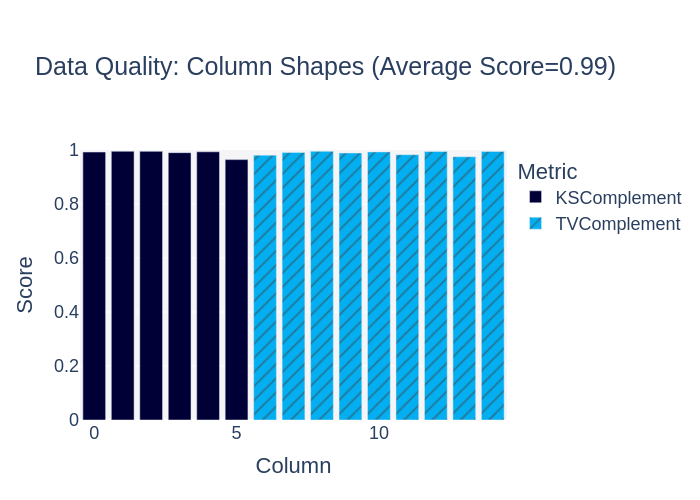

In [35]:
fig = qual_report.get_visualization(property_name='Column Shapes')
fig.show(renderer='png')

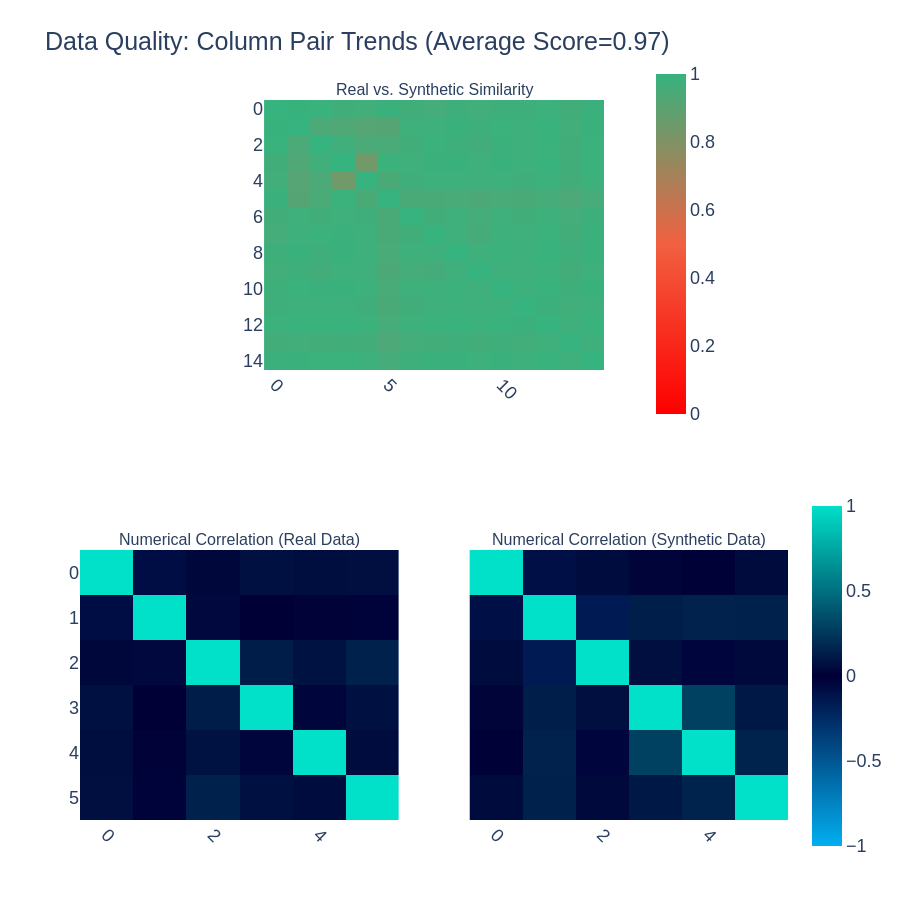

In [36]:
fig = qual_report.get_visualization(property_name='Column Pair Trends')
fig.show(renderer='png')

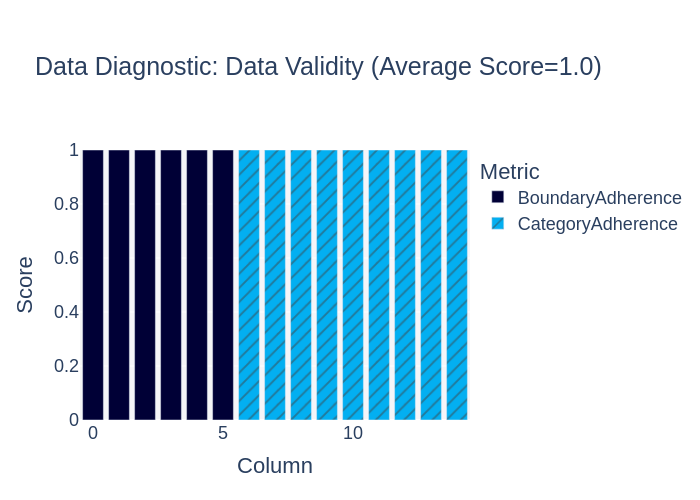

In [37]:
fig = diag_report.get_visualization(property_name='Data Validity')
fig.show(renderer='png')

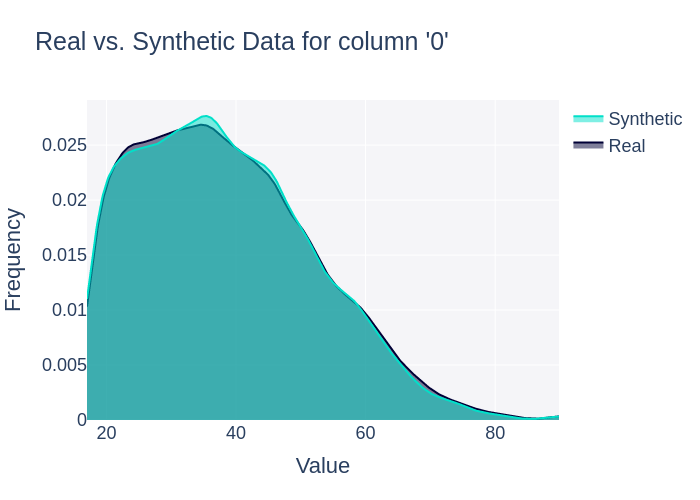

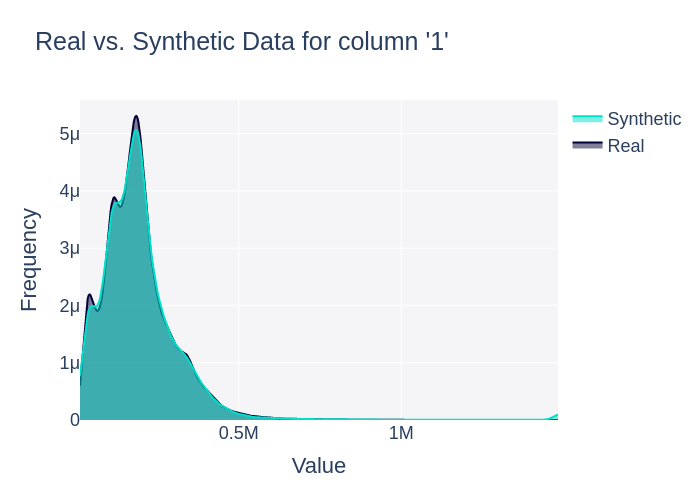

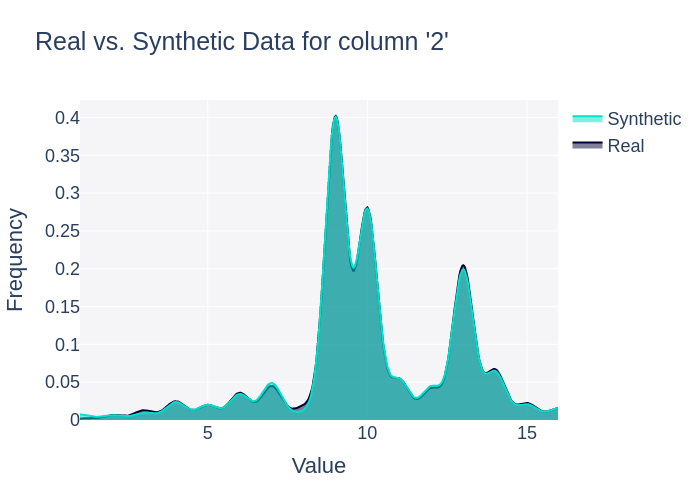

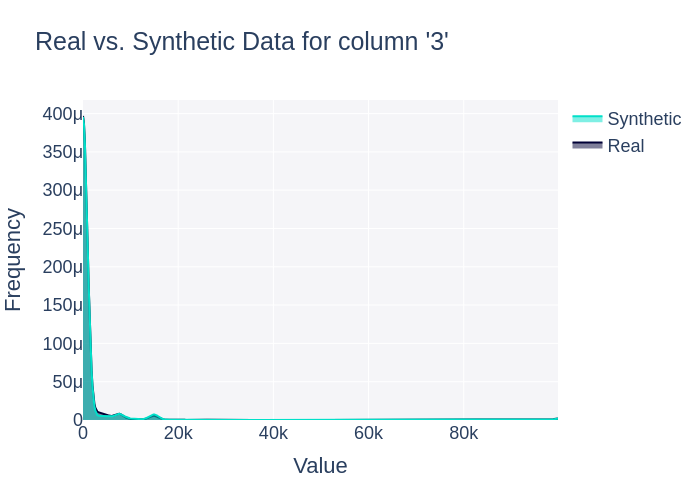

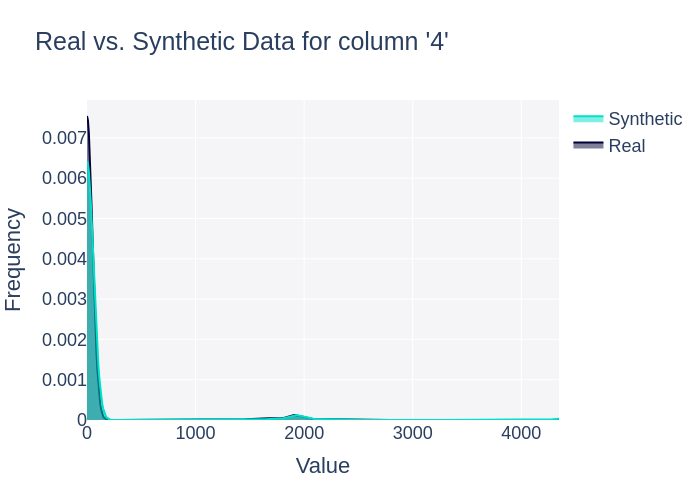

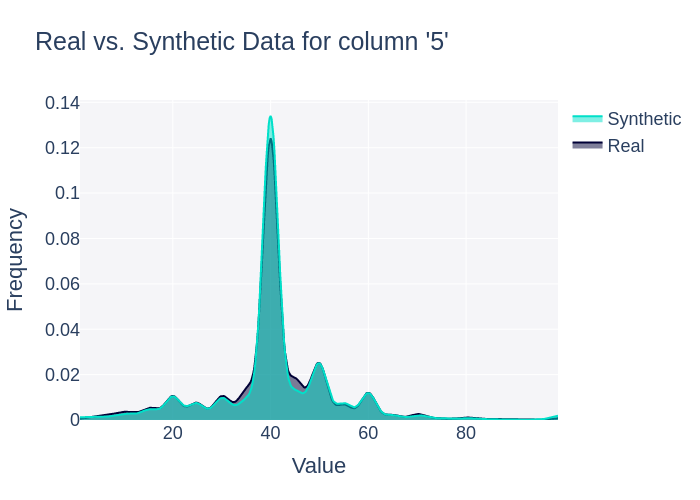

In [38]:
from sdmetrics.visualization import get_column_plot
for i in range(0, 6):
    fig = get_column_plot(
        real_data=new_real_data,
        synthetic_data=new_syn_data,
        column_name=i,
        plot_type='distplot'
    )

    fig.show(renderer='png')

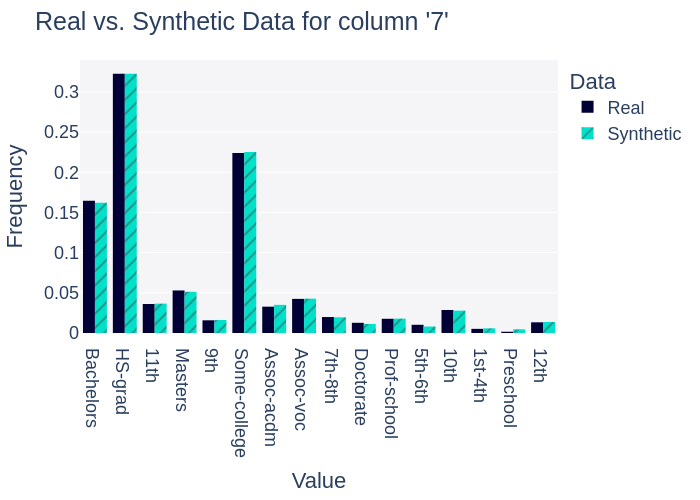

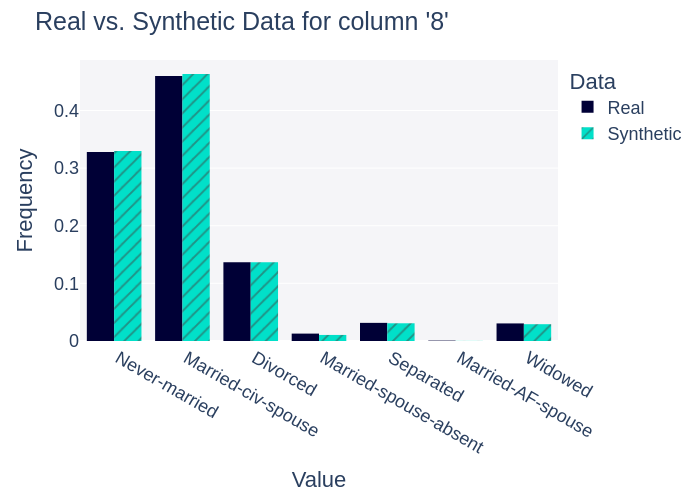

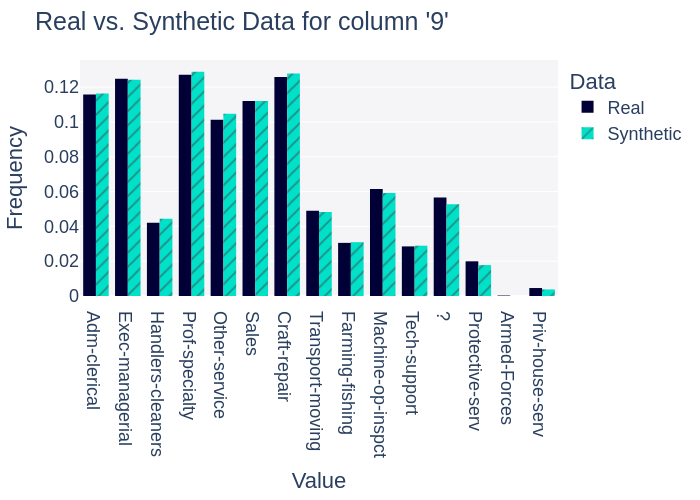

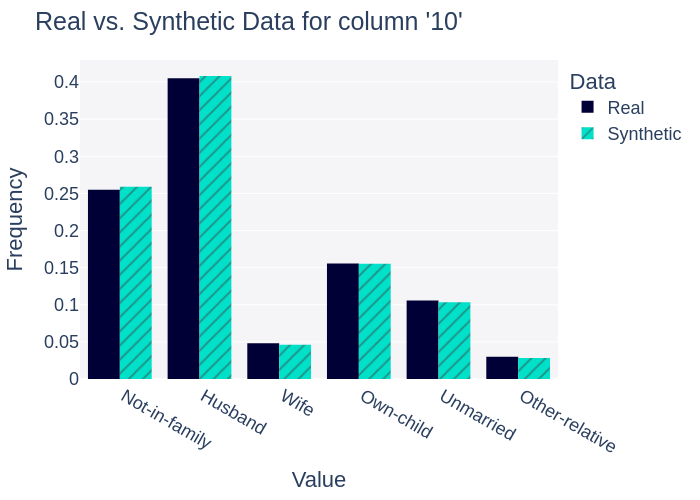

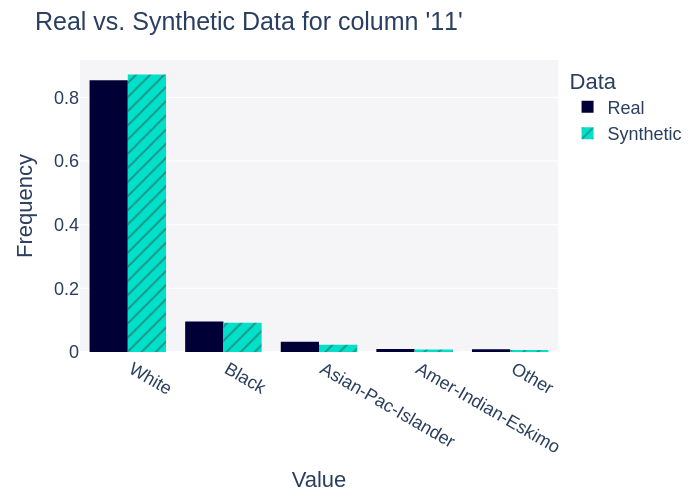

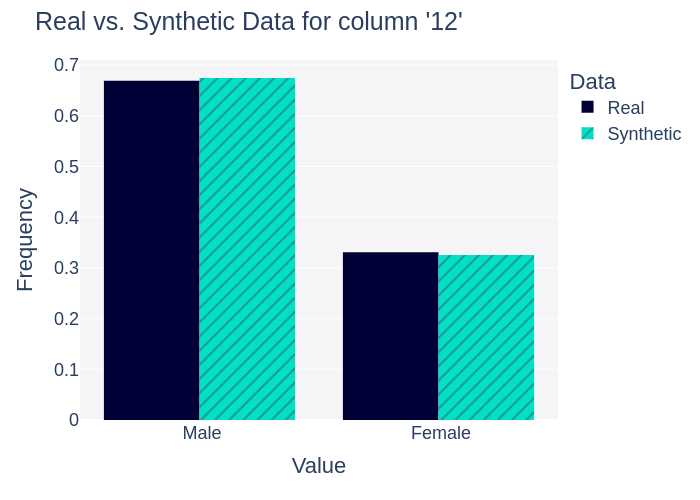

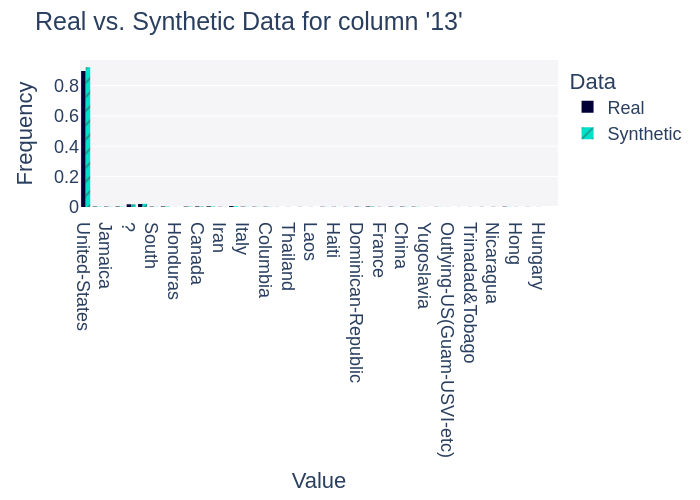

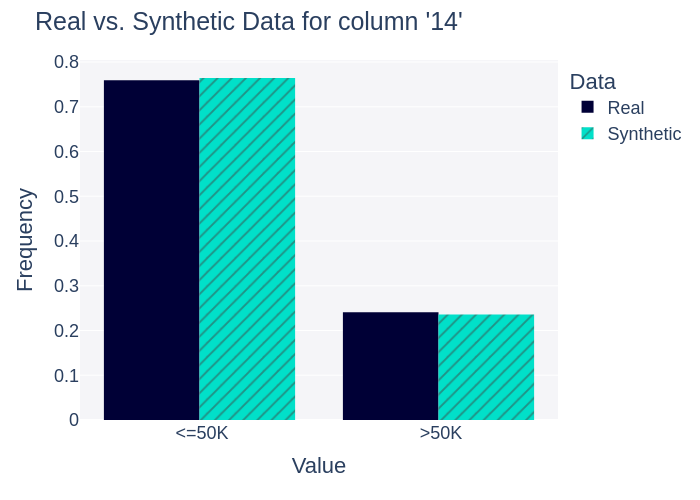

In [39]:
for i in range(7, 15):
    fig = get_column_plot(
        real_data=new_real_data,
        synthetic_data=new_syn_data,
        column_name=i,
        plot_type='bar'
    )

    fig.show(renderer='png')

### DCR

In [42]:
pd.options.mode.chained_assignment = None
dataname = 'adult'
model = 'model'
syn_path = 'synthetic/synthetic.csv'
real_path = 'synthetic/real.csv'
test_path = 'synthetic/test.csv'
data_dir = '/content/drive/MyDrive/adult'

def DCR(dataname = dataname, model = model, syn_path = syn_path, real_path = real_path,test_path = test_path, data_dir = data_dir ):
    with open(f'{data_dir}/info.json', 'r') as f:
        info = json.load(f)

    syn_data = pd.read_csv(syn_path)
    real_data = pd.read_csv(real_path)
    test_data = pd.read_csv(test_path)

    num_col_idx = info['num_col_idx']
    cat_col_idx = info['cat_col_idx']
    target_col_idx = info['target_col_idx']

    task_type = info['task_type']
    if task_type == 'regression':
        num_col_idx += target_col_idx
    else:
        cat_col_idx += target_col_idx

    num_ranges = []

    real_data.columns = list(np.arange(len(real_data.columns)))
    syn_data.columns = list(np.arange(len(real_data.columns)))
    test_data.columns = list(np.arange(len(real_data.columns)))
    for i in num_col_idx:
        num_ranges.append(real_data[i].max() - real_data[i].min())

    num_ranges = np.array(num_ranges)


    num_real_data = real_data[num_col_idx]
    cat_real_data = real_data[cat_col_idx]
    num_syn_data = syn_data[num_col_idx]
    cat_syn_data = syn_data[cat_col_idx]
    num_test_data = test_data[num_col_idx]
    cat_test_data = test_data[cat_col_idx]

    num_real_data_np = num_real_data.to_numpy()
    cat_real_data_np = cat_real_data.to_numpy().astype('str')
    num_syn_data_np = num_syn_data.to_numpy()
    cat_syn_data_np = cat_syn_data.to_numpy().astype('str')
    num_test_data_np = num_test_data.to_numpy()
    cat_test_data_np = cat_test_data.to_numpy().astype('str')

    encoder = OneHotEncoder()
    encoder.fit(cat_real_data_np)


    cat_real_data_oh = encoder.transform(cat_real_data_np).toarray()
    cat_syn_data_oh = encoder.transform(cat_syn_data_np).toarray()
    cat_test_data_oh = encoder.transform(cat_test_data_np).toarray()

    num_real_data_np = num_real_data_np / num_ranges
    num_syn_data_np = num_syn_data_np / num_ranges
    num_test_data_np = num_test_data_np / num_ranges

    real_data_np = np.concatenate([num_real_data_np, cat_real_data_oh], axis=1)
    syn_data_np = np.concatenate([num_syn_data_np, cat_syn_data_oh], axis=1)
    test_data_np = np.concatenate([num_test_data_np, cat_test_data_oh], axis=1)

    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'

    real_data_th = torch.tensor(real_data_np).to(device)
    syn_data_th = torch.tensor(syn_data_np).to(device)
    test_data_th = torch.tensor(test_data_np).to(device)

    dcrs_real = []
    dcrs_test = []
    batch_size = 100

    batch_syn_data_np = syn_data_np[i*batch_size: (i+1) * batch_size]

    for i in range((syn_data_th.shape[0] // batch_size) + 1):
        if i != (syn_data_th.shape[0] // batch_size):
            batch_syn_data_th = syn_data_th[i*batch_size: (i+1) * batch_size]
        else:
            batch_syn_data_th = syn_data_th[i*batch_size:]

        dcr_real = (batch_syn_data_th[:, None] - real_data_th).abs().sum(dim = 2).min(dim = 1).values
        dcr_test = (batch_syn_data_th[:, None] - test_data_th).abs().sum(dim = 2).min(dim = 1).values
        dcrs_real.append(dcr_real)
        dcrs_test.append(dcr_test)

    dcrs_real = torch.cat(dcrs_real)
    dcrs_test = torch.cat(dcrs_test)


    score = (dcrs_real < dcrs_test).nonzero().shape[0] / dcrs_real.shape[0]

    print('DCR Score, a value closer to 0.5 is better')
    print(f'{dataname}-{model}, DCR Score = {score}')

In [43]:
DCR()

DCR Score, a value closer to 0.5 is better
adult-model, DCR Score = 0.6780811400141273


### C2ST

In [44]:
import numpy as np
import torch
import pandas as pd
import os
import sys

import json
import pickle

# Metrics
from sdmetrics import load_demo
from sdmetrics.single_table import LogisticDetection

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

def reorder(real_data, syn_data, info):
    num_col_idx = info['num_col_idx']
    cat_col_idx = info['cat_col_idx']
    target_col_idx = info['target_col_idx']

    task_type = info['task_type']
    if task_type == 'regression':
        num_col_idx += target_col_idx
    else:
        cat_col_idx += target_col_idx

    real_num_data = real_data[num_col_idx]
    real_cat_data = real_data[cat_col_idx]

    new_real_data = pd.concat([real_num_data, real_cat_data], axis=1)
    new_real_data.columns = range(len(new_real_data.columns))

    syn_num_data = syn_data[num_col_idx]
    syn_cat_data = syn_data[cat_col_idx]

    new_syn_data = pd.concat([syn_num_data, syn_cat_data], axis=1)
    new_syn_data.columns = range(len(new_syn_data.columns))


    metadata = info['metadata']

    columns = metadata['columns']
    metadata['columns'] = {}

    inverse_idx_mapping = info['inverse_idx_mapping']


    for i in range(len(new_real_data.columns)):
        if i < len(num_col_idx):
            metadata['columns'][i] = columns[num_col_idx[i]]
        else:
            metadata['columns'][i] = columns[cat_col_idx[i-len(num_col_idx)]]


    return new_real_data, new_syn_data, metadata


def detection(dataname = dataname, model = model, syn_path = syn_path, real_path = real_path,test_path = test_path, data_dir = data_dir ):
    with open(f'{data_dir}/info.json', 'r') as f:
        info = json.load(f)

    syn_data = pd.read_csv(syn_path)
    real_data = pd.read_csv(real_path)

    save_dir = f'eval/density/{dataname}/{model}'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    real_data.columns = range(len(real_data.columns))
    syn_data.columns = range(len(syn_data.columns))

    metadata = info['metadata']
    metadata['columns'] = {int(key): value for key, value in metadata['columns'].items()}

    new_real_data, new_syn_data, metadata = reorder(real_data, syn_data, info)

    # qual_report.generate(new_real_data, new_syn_data, metadata)

    score = LogisticDetection.compute(
        real_data=new_real_data,
        synthetic_data=new_syn_data,
        metadata=metadata
    )

    print(f'{dataname}, {model}: {score}')

In [45]:
detection()

adult, model: 0.9581213341922687
